# Supervised Learning for Best Model

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import os
import json
import boto3
import datetime
import contractions
from collections import Counter
import mysql.connector
from mysql.connector import Error
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score,f1_score
from sklearn.metrics import auc, average_precision_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from string import punctuation
import re
import mlflow
from mlflow.tracking import MlflowClient
# mlflow.set_tracking_uri("sqlite:///mlflow.db")
# mlflow.set_experiment("sentiment-hate-experiment")
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("white")
plt.rcParams['figure.figsize'] = (18, 5)
import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)
import sys
# Path to the module (ModelInference) and config
sys.path.append('/home/chuby/Desktop/programming/NLP/sentiment-hate-system/src')
from pipeline.modelinference import ModelInference
from config import config

In [3]:
mlflow.get_tracking_uri()

'file:///home/chuby/Desktop/programming/NLP/sentiment-hate-system/src/train/mlruns'

In [3]:
# EXPERIMENT_NAME = "sentiment-hate-experiment"
# TRACKING_URI = 'http://127.0.0.1:5000'

AWS_ACCESS_KEY_ID = os.getenv('access_key_id')
AWS_SECRET_ACCESS_KEY = os.getenv('secret_access_key')

EXPERIMENT_NAME = "sentiment-hate-experiment"
TRACKING_SERVER_HOST = 'ec2-3-82-98-49.compute-1.amazonaws.com'
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:5000")
# Initialize client
client = MlflowClient()

# If experiment doesn't exist then it will create new
# else it will take the experiment id and will use it to run the experiments
try:
    # Create experiment 
    experiment_id = client.create_experiment(EXPERIMENT_NAME)
except:
    # Get the experiment id if it already exists
    experiment_id = client.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

print(mlflow.get_tracking_uri())

http://ec2-3-82-98-49.compute-1.amazonaws.com:5000


In [4]:
class ToPandasDF():
    def __init__(self, password, host, database, user):

        self.password = password
        self.host = host
        self.database = database
        self.user = user
        
    
    def MySQLconnect(self, query):
        
        try:
            connection = mysql.connector.connect(host=self.host, 
                                                 database=self.database, 
                                                 password=self.password,
                                                 user=self.user)

            if connection.is_connected():

                print("Successfully connected to the database\n")

                cursor = connection.cursor()
                query = query
                cursor.execute(query)

                data = cursor.fetchall()

                df = pd.DataFrame(data, columns = ['id', 'date', 'tweet'])
        except Error as e:
            print(e)
            
        cursor.close()
        connection.close()
        
        return df
    
    def check_if_valid_data(self, data):
        
        # Create a timestamp of the date(Day, Month & Year)
        data['timestamp'] = data['date'].apply(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d'))
        
        if data.empty:
            print("No tweets downloaded. Finishing execution")
            
        if data['id'].unique().all():
            pass
        else:
            print(f"Primary Key check is violated, Number of duplicate values: {data.duplicated().sum()}")
            
        if data.isnull().values.any():
            print(f"\nNull values detected, Number of null: \n{data.isnull().sum()}")
        
        yesterday = datetime.datetime.now() - datetime.timedelta(days=1)
        yesterday = yesterday.replace(hour=0, minute=0, second=0, microsecond=0)
        timestamps = data['timestamp'].tolist()
        for timestamp in timestamps:
            if datetime.datetime.strptime(timestamp, '%Y-%m-%d') != yesterday:
                print("Atleast one of the returned tweet does not come from within the last 24 hours")
        
    def basic_processing(self, data):
        data = data.drop(['date', 'timestamp'], axis=1)
        print(f'\nTotal Tweets in the DataLake: {data.shape[0]}')
        print(f'Number of duplicate entry of unlabelled data: {data.tweet.duplicated().sum()}')
        # Remove duplicates
        data = data[~data.tweet.duplicated()]
        print(f'{data.tweet.duplicated().sum()} Number of duplicate entry after removal')
        # We will remove the usernames and RT(retweet) in the tweet column
        data['tweet'] = data.tweet.replace(regex=re.compile(r"@([A-Za-z0-9_]+)"), value='')
        data['tweet'] = data.tweet.replace(regex=re.compile(r"RT([\s:]+)"), value='')
        return data

    def load_train_data(self):
        data1 = pd.read_csv(os.path.join(config.DATAPATH, 'train.csv'))
        data2 = pd.read_csv(os.path.join(config.DATAPATH, 'HateSpeechData.csv'), index_col=0)
        data2 = data2.rename(columns={'hate_speech':'hate', 'offensive_language':'offensive',
                                      'neither':'neutral', 'class':'label'
                                     })
        # Remove all records with no label
        data1 = data1[data1.label != '']
        return data1, data2

if __name__ == '__main__':
    
    t = ToPandasDF(config.PASSWORD, config.HOST, config.DATABASE, config.USER)
    stored_data = t.MySQLconnect("SELECT id, created_at, tweet FROM `twitterdb`.`twitter_table`;")
    t.check_if_valid_data(stored_data)
    unlabelled_data = t.basic_processing(stored_data)
    data1, data2 = t.load_train_data()

Successfully connected to the database

Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the retur

In [5]:
print(unlabelled_data.shape)
unlabelled_data.info()
unlabelled_data = unlabelled_data.reset_index()
unlabelled_data.head(10)

(5329, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5329 entries, 0 to 7303
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5329 non-null   object
 1   tweet   5329 non-null   object
dtypes: object(2)
memory usage: 124.9+ KB


,index,id,tweet
0,0,1570399058065498114,#Leather #stores and their #suppliers need to#...
1,1,1570457629159489536,""" has welcomed the joint statement from US Sen..."
2,2,1570495497252777984,#why do you feel #constant #abuse to me person...
3,3,1570512580803952642,Biden urges Americans to combat hate and extre...
4,4,1570683999919673346,"Join Jenna, one of our special guest, as she t..."
5,5,1570759533621805060,Behaviors that Might Increase the Risk of Non-...
6,6,1570797612147814400,50 people is considered an influx and too much...
7,7,1570827930854653954,what you can do? my only option in 23 years is...
8,8,1570862771083911173,#Hadith \n#HadithOfTheDay \n#ProphetMuhammad (...
9,9,1570873351475961859,You are the one\nwho must decide\nwhat your co...


In [6]:
# 0=hate, 1=offensive, 2=neutral
print(data2.shape)
print()
print(data2.label.value_counts())
data2.info()
data2.head(10)

(24783, 6)

1    19190
2     4163
0     1430
Name: label, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 24783 entries, 0 to 25296
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   count      24783 non-null  int64 
 1   hate       24783 non-null  int64 
 2   offensive  24783 non-null  int64 
 3   neutral    24783 non-null  int64 
 4   label      24783 non-null  int64 
 5   tweet      24783 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.3+ MB


,count,hate,offensive,neutral,label,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up ..."
7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...
8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ..."
9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Maria..."


In [7]:
print(data2[data2.label==1].tweet.iloc[9])
data2[['label', 'tweet']].tail(10)

" Keeks is a bitch she curves everyone " lol I walked into a conversation like this. Smh


,label,tweet
25286,1,you niggers cheat on ya gf's? smh....
25287,1,you really care bout dis bitch. my dick all in...
25288,1,"you worried bout other bitches, you need me for?"
25289,0,you're all niggers
25290,0,you're such a retard i hope you get type 2 dia...
25291,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
25292,2,"you've gone and broke the wrong heart baby, an..."
25294,1,young buck wanna eat!!.. dat nigguh like I ain...
25295,1,youu got wild bitches tellin you lies
25296,2,~~Ruffled | Ntac Eileen Dahlia - Beautiful col...


In [8]:
data2 = data2.copy()
data2 = data2[['label', 'tweet']]
# Create the hate and non-hate categories by combining hate and offensive categories
# 0=hate, 1=offensive, 2=neutral
data2['label'] = data2.label.replace([1], 0).replace([0], 1).replace([2], 0)
print(data2.label.value_counts())
# New label 1=hate & 0=non-hate 
data2[['label', 'tweet']].tail(10)

1    20620
0     4163
Name: label, dtype: int64


,label,tweet
25286,1,you niggers cheat on ya gf's? smh....
25287,1,you really care bout dis bitch. my dick all in...
25288,1,"you worried bout other bitches, you need me for?"
25289,1,you're all niggers
25290,1,you're such a retard i hope you get type 2 dia...
25291,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
25292,0,"you've gone and broke the wrong heart baby, an..."
25294,1,young buck wanna eat!!.. dat nigguh like I ain...
25295,1,youu got wild bitches tellin you lies
25296,0,~~Ruffled | Ntac Eileen Dahlia - Beautiful col...


In [9]:
# Initialize the TfidfVectorizer, Lemmatizer and stopwords
# tfVectorizer = TfidfVectorizer(min_df=0.0, max_df=1.0, max_features=800, ngram_range=(1, 1), use_idf=True)
# tfVectorizer = TfidfVectorizer(min_df=5, max_df=0.75, max_features=1000, ngram_range=(1, 2))
tfVectorizer = TfidfVectorizer(sublinear_tf=True, 
                               min_df=5, norm='l2', encoding='latin-1', max_features=1000,
                               ngram_range=(1, 2))

lemmatizer = WordNetLemmatizer()
stopwords = set(json.load(open("/home/daniel/programming/NLP/sentiment-hate-system/src/stopWords/custome_nltk_stopwords.json", "r")))
stopwords_json = set(json.load(open("/home/daniel/programming/NLP/sentiment-hate-system/src/stopWords/custome_json_stopwords.json", "r")))
stopwords_punctuation = set.union(stopwords, stopwords_json, punctuation)

labelled_data = pd.concat([data1, data2], axis=0).reset_index()
labelled_data = labelled_data.drop('id', axis=1)
labelled_data = labelled_data.rename(columns={'index':'id'})
print(labelled_data.shape)
labelled_data.info()
labelled_data.head(10)

(56745, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56745 entries, 0 to 56744
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      56745 non-null  int64 
 1   label   56745 non-null  int64 
 2   tweet   56745 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.3+ MB


,id,label,tweet
0,0,0,@user when a father is dysfunctional and is s...
1,1,0,@user @user thanks for #lyft credit i can't us...
2,2,0,bihday your majesty
3,3,0,#model i love u take with u all the time in ...
4,4,0,factsguide: society now #motivation
5,5,0,[2/2] huge fan fare and big talking before the...
6,6,0,@user camping tomorrow @user @user @user @use...
7,7,0,the next school year is the year for exams.ð...
8,8,0,we won!!! love the land!!! #allin #cavs #champ...
9,9,0,@user @user welcome here ! i'm it's so #gr...


# Target Exploration (label)

In [10]:
labelled_data.label.value_counts()

0    33883
1    22862
Name: label, dtype: int64

**The dataset is imbalanced based on hate speech**

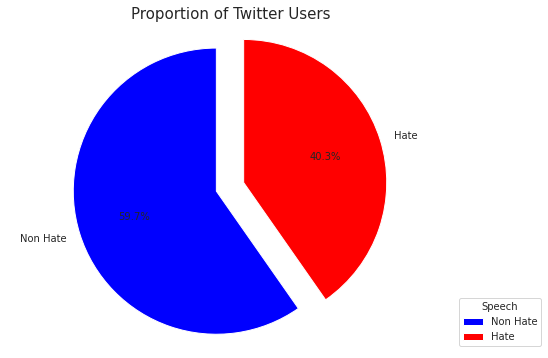

In [11]:
size=labelled_data.label.value_counts()
labels='Non Hate', 'Hate'
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(size, explode=(0, 0.2), labels=labels, autopct='%1.1f%%', startangle=90, colors=['blue', 'red'])
ax.axis('equal')
plt.title('Proportion of Twitter Users', size=15)
ax.legend(labels, bbox_to_anchor=(1, 0), loc='lower left', title='Speech')
plt.show()

It is given that 40.3% of twitter users might Hate. So the baseline model could be to predict that 40.3% of the users will Hate. Given 40.3% is a small number, we need to ensure that the chosen model does predict with great accuracy this 40.3% as it is of interest to the company to identify these users as opposed to accurately predicting the users that are non haters.

In [12]:
def basic_prep(data):
    data['mention_count'] = data.tweet.apply(lambda x: len(re.findall(r"@[\w\-]+", x)))
    data['tweet'] = data.tweet.replace(regex=re.compile(r"@([A-Za-z0-9_]+)"), value='')
    data['tweet'] = data.tweet.replace(regex=re.compile(r"RT([\s:]+)"), value='')
    return data

def preprocess_text(text):
    
    """Function to clean text from irrelevant words and symbols"""
    
    if type(text) == float:
        print('Entry not valid')
        return ""
    sentence = []
    
    # Tokenize and lowercase all alphabet
    tokens = [contractions.fix(i.lower()) for i in word_tokenize(str(text))]
    
    # Part of speech
    tags = pos_tag(tokens)
    
    for (token, tag) in tags:
        # Remove all irrelevant symbols from token
        token = re.sub(r"([0-9]+|[-_@./&+]+|``)", '', token)
        token = re.sub(r"(@[A-Za-z0-9_]+)|[^\w\s]|#|http\S+", '', token)
        token = token.encode("ascii", "ignore")
        token = token.decode()
        
        # Grab the positions of the nouns(NN), verbs(VB), adverb(RB), and adjective(JJ)
        if tag.startswith('NN'):
            position = 'n'
        elif tag.startswith('VB'):
            position = 'v'
        elif tag.startswith('RB'):
            position = 'r'
        else:
            position = 'a'

        lemmatized_word = lemmatizer.lemmatize(token, position)
        if lemmatized_word not in stopwords_punctuation:
            sentence.append(lemmatized_word)
    final_sent = ' '.join(sentence)
    final_sent = final_sent.replace("n't", 'not').replace("nt", "not")
    return final_sent

data_cleaned = labelled_data.copy()
data_cleaned = basic_prep(data_cleaned)
data_cleaned['cleaned_text'] = data_cleaned.tweet.apply(preprocess_text)
print(f'The longest for labelled tweet is: {max(data_cleaned.cleaned_text.str.len())}')
print(f'The shortest for labelled tweet is: {min(data_cleaned.cleaned_text.str.len())}')

unlabelled_cleaned = unlabelled_data.copy()
unlabelled_cleaned = basic_prep(unlabelled_cleaned)
unlabelled_cleaned['cleaned_text'] = unlabelled_cleaned.tweet.apply(preprocess_text)
print(f'The longest for unlabelled tweet is: {max(unlabelled_cleaned.cleaned_text.str.len())}')
print(f'The shortest for unlabelled tweet is: {min(unlabelled_cleaned.cleaned_text.str.len())}')

The longest for labelled tweet is: 339
The shortest for labelled tweet is: 0
The longest for unlabelled tweet is: 304
The shortest for unlabelled tweet is: 0


# Visualize Word frequency

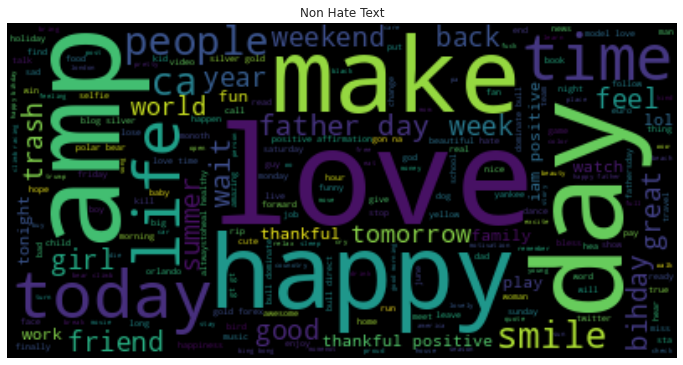

In [13]:
# Let's split the dataset into non hate(0) and hate(1) so as to visualize the frequency of the words
no_hate = data_cleaned[data_cleaned['label']==0]
hate = data_cleaned[data_cleaned['label']==1]

wordcloud = WordCloud(background_color='black').generate(' '.join(no_hate.cleaned_text))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Non Hate Text')
plt.axis('off')
plt.show()

**Above, we can see that those are `non-hate` related words**

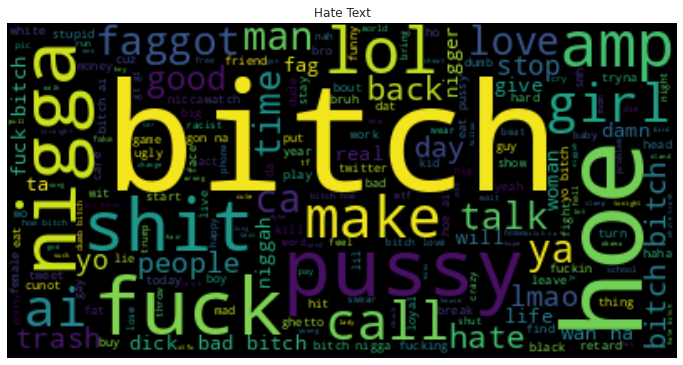

In [14]:
wordcloud = WordCloud(background_color='black').generate(' '.join(hate.cleaned_text))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Hate Text')
plt.axis('off')
plt.show()

In [15]:
# We will encode text data using TF-IDF
def transform(data_cleaned, unlabelled_cleaned):
    tfVectorizer.fit(data_cleaned.cleaned_text)
    train_tfidf_feat = tfVectorizer.transform(data_cleaned.cleaned_text).toarray()
    unlabelled_tfidf_feat = tfVectorizer.transform(unlabelled_cleaned.cleaned_text).toarray()
    train_tfidf = pd.DataFrame(train_tfidf_feat, columns=tfVectorizer.get_feature_names_out())
    unlabelled_tfidf = pd.DataFrame(unlabelled_tfidf_feat, columns=tfVectorizer.get_feature_names_out())
    return tfVectorizer, train_tfidf, unlabelled_tfidf

def merge(tfidf, data_to_merge):
    # Join both DataFrames
    data = tfidf.merge(data_to_merge, left_index=True, right_index=True)
    data = data.drop(['cleaned_text'], axis=1)
    return data

tfVectorizer, data_train_tfidf, unlabelled_tfidf = transform(data_cleaned, unlabelled_cleaned)

# Feature Engineering

## Frequency distribution of Part of Speech Tags

In [16]:
%%time 
pos_group = {
    'noun':['NN','NNS','NNP','NNPS'],
    'pron':['PRP','PRP$','WP','WP$'],
    'verb':['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj':['JJ','JJR','JJS'],
    'adv':['RB','RBR','RBS','WRB']
}

        
def count_pos_tag(text, flags):
    
    """Function to check and count the respective parts of speech tags"""
    
    count=0
    tokens = [contractions.fix(i.lower()) for i in word_tokenize(text)]
    tags = pos_tag(tokens)

    for (token, tag) in tags:
        token = re.sub(r"([0-9]+|[-_@./&+]+|``)", '', token)
        token = re.sub(r"(@[A-Za-z0-9_]+)|[^\w\s]|#|http\S+", '', token)
        token = token.encode("ascii", "ignore")
        token = token.decode()
        if tag in pos_group[flags]:
            count+=1
    return count

def make_features(data):

    data['noun_count'] = data.tweet.apply(lambda x: count_pos_tag(x, 'noun'))
    data['verb_count'] = data.tweet.apply(lambda x: count_pos_tag(x, 'verb'))
    data['adj_count'] = data.tweet.apply(lambda x: count_pos_tag(x, 'adj'))
    data['adv_count'] = data.tweet.apply(lambda x: count_pos_tag(x, 'adv'))
    data['pron_count'] = data.tweet.apply(lambda x: count_pos_tag(x, 'pron'))

    data['char_count'] = data.tweet.apply(len)
    data['word_count'] = data.tweet.apply(lambda x: len(x.split()))
    data['uniq_word_count'] = data.tweet.apply(lambda x: len(set(x.split())))
    data['htag_count'] = data.tweet.apply(lambda x: len(re.findall(r'#[\w\-]+', x)))
    data['stopword_count'] = data.tweet.apply(lambda x: len([wrd for wrd in word_tokenize(x) if wrd in stopwords]))
    data['sent_count'] = data.tweet.apply(lambda x: len(sent_tokenize(x)))
    data['avg_word_len'] = data['char_count']/(data['word_count']+1)
    data['avg_sent_len'] = data['word_count']/(data['sent_count']+1)
    data['uniq_vs_words'] = data.uniq_word_count/(data.word_count+1) # Ratio of unique words to the total number of words
    data['stopwords_vs_words'] = data.stopword_count/(data.word_count+1)
    data['title_word_count'] = data.tweet.apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
    data['uppercase_count'] = data.tweet.apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
    data = data.drop(['id', 'tweet'], axis=1)
    return data


data_cleaned = make_features(data_cleaned)
unlabelled_cleaned = make_features(unlabelled_cleaned)

data_cleaned = merge(data_train_tfidf, data_cleaned)
unlabelled_cleaned = merge(unlabelled_tfidf, unlabelled_cleaned)

CPU times: user 5min 21s, sys: 2.34 s, total: 5min 24s
Wall time: 5min 23s


In [17]:
target_labelled_data = data_cleaned.label
data_cleaned = data_cleaned.drop(['label'], axis=1)
unlabelled_cleaned = unlabelled_cleaned.drop(['index'], axis=1)
print(f"Number of columns of the data_cleaned: {data_cleaned.shape[1]}")
print(f"Number of columns of the unlabelled_cleaned: {unlabelled_cleaned.shape[1]}")
print()
X_train, X_test, y_train, y_test = train_test_split(data_cleaned.values, target_labelled_data.values,
                                                    test_size=0.2, random_state=43)

print(f"Train Size: {(X_train.shape[0]/data_cleaned.shape[0]):.2f}%")
print(f"Test Size: {(X_test.shape[0]/data_cleaned.shape[0]):.2f}%")
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, unlabelled_cleaned.shape)

def confusion_matrix_plot(cm, normalized= True, cmap= 'bone'):
    norm_cm = cm
    if normalized:
        plt.figure(figsize=(6,4))
        norm_cm = (cm.astype('float')/ cm.sum(axis= 1)[:, np.newaxis])
        return sns.heatmap(norm_cm, annot= cm, fmt='g', 
                           xticklabels= ['Predicted: No Hate', 'Predicted: Yes Hate'],
                           yticklabels=['Actual: No Hate', 'Actual: Yes Hate'])

def roc_auc_curve(y_test, prob):
    plt.figure(figsize=(14, 8))
    fpr, tpr, _ = roc_curve(y_test, prob)
    auc = roc_auc_score(y_test, prob)
    plt.plot(fpr, tpr, label= f"Validation AUC-ROC={str(auc)}")
    x = np.linspace(0, 1, 1000)
    plt.plot(x, x, linestyle='-')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)

def train(model, scaler, X_train, y_train, X_test):
    
    """Sklearn training interface
    """
    pipeline = make_pipeline(scaler, model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    test_prob = pipeline.predict_proba(X_test)[:, 1]
    train_prob = pipeline.predict_proba(X_train)[:, 1]
    return y_pred, test_prob, train_prob


tags = {"application":"Sentiment Hate Detector",
        "developer": "daniel",
        "train-data1-path": f"{os.path.join(config.DATAPATH, 'train.csv')}",
        "train-data2-path": f"{os.path.join(config.DATAPATH, 'HateSpeechData.csv')}"}

Number of columns of the data_cleaned: 1018
Number of columns of the unlabelled_cleaned: 1018

Train Size: 0.80%
Test Size: 0.20%
(45396, 1018) (45396,) (11349, 1018) (11349,) (5329, 1018)


In [18]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

def binary_predict(probs):
    """Function to convert LightGBM .predict output to binary (0, 1)"""
    y_pred=(probs > 0.5).astype("int")
    return y_pred

# Check for Missing Values

In [19]:
print(pd.isnull(data_cleaned).sum().sort_values(ascending=False))

about              0
police             0
pig                0
pink               0
piss               0
                  ..
friendship         0
fronot             0
fuck               0
fuck bitch         0
uppercase_count    0
Length: 1018, dtype: int64


In [20]:
print(pd.isnull(unlabelled_cleaned).sum().sort_values(ascending=False))

about              0
police             0
pig                0
pink               0
piss               0
                  ..
friendship         0
fronot             0
fuck               0
fuck bitch         0
uppercase_count    0
Length: 1018, dtype: int64


# Model Building & Evaluation

## MLflow for Model Tracking and Experiment

In [21]:
# !mlflow ui --backend-store-uri sql|ite:///mlflow.db

### Get the best Model to perform Pseudo-Labelling (Semi-Supervised Learning) on the unlabelled_data

## MultinomialNB & Parameter tuning

In [22]:
with mlflow.start_run():
    for a in [0.0001, 0.001, 0.01, 0.1, 1, 10]:
        y_pred, test_prob, train_prob = train(MultinomialNB(alpha=a), MinMaxScaler(), X_train, y_train, X_test)
        train_auc = roc_auc_score(y_train, train_prob)
        test_auc = roc_auc_score(y_test, test_prob)
        
        with mlflow.start_run(experiment_id=experiment_id, run_name='multi-tuning', nested=True):
            mlflow.set_tags(tags)
            mlflow.log_params({"alpha":a,
                               "percent-misclassified":np.mean(y_pred != y_test)*100})
            mlflow.log_metrics({"train-auc-score":train_auc,
                                "test-auc-score":test_auc})
        print(f"{a}->{train_auc:.4f}")
        print(f"{a}->{test_auc:.4f}")
#     mlflow.end_run()

0.0001->0.9639
0.0001->0.9639
0.001->0.9638
0.001->0.9640
0.01->0.9638
0.01->0.9641
0.1->0.9637
0.1->0.9642
1->0.9639
1->0.9645
10->0.9648
10->0.9655


Train ROC AUC Naive Bayes Score: 0.9648
Test ROC AUC Naive Bayes Score: 0.9655
'%' of Misclassified class: 8.837783064587189


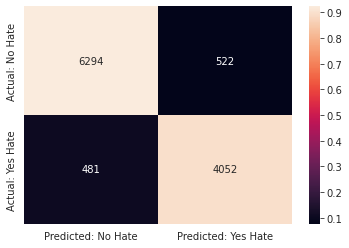

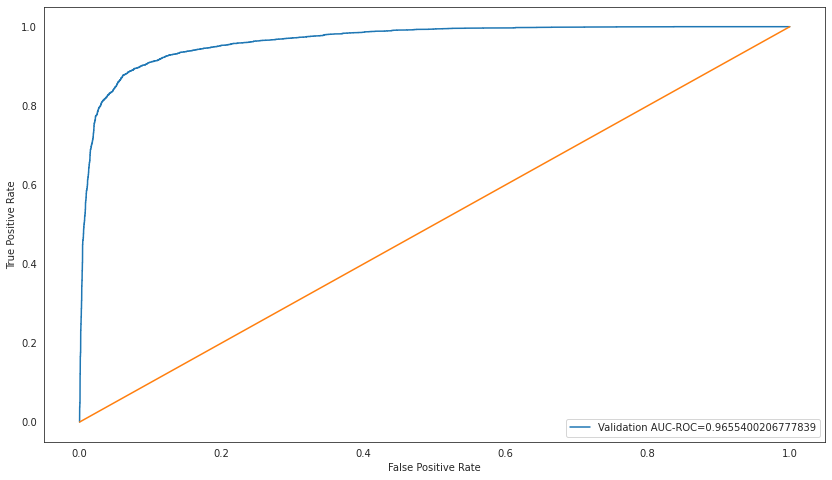

In [24]:
with mlflow.start_run(experiment_id=experiment_id, run_name='multi-final'):
    mlflow.set_tags(tags)
    
    a=10
    scaler=MinMaxScaler()
    y_pred, test_prob, train_prob = train(MultinomialNB(alpha=a), MinMaxScaler(), X_train, y_train, X_test)
    train_auc = roc_auc_score(y_train, train_prob)
    test_auc = roc_auc_score(y_test, test_prob)
    misclass = np.mean(y_pred != y_test)*100
    
    mlflow.log_param("alpha",a)
    mlflow.log_param("scaler",scaler)
    mlflow.log_param("percent-misclassified",misclass)
    mlflow.log_metrics({"train-auc-score":train_auc,
                        "test-auc-score":test_auc})
    
print(f"Train ROC AUC Naive Bayes Score: {train_auc:.4f}")
print(f"Test ROC AUC Naive Bayes Score: {test_auc:.4f}")
print(f"'%' of Misclassified class: {misclass}")
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, test_prob)
plt.show()

The orange line seen here represents the random selection. What it says is that if i get 50% of the False Positives in my random selection, I also get 50% of the True Positives or True Users that will hate.

## Logistic Regression & Parameter tuning

In [25]:
with mlflow.start_run():
    
    for c in [0.00005, 0.0001, 0.001, 0.01, 0.1, 1]:
        y_pred, test_prob, train_prob = train(LogisticRegression(solver='liblinear', C=c), StandardScaler(),
                             X_train, y_train, X_test)
        
        train_auc = roc_auc_score(y_train, train_prob)
        test_auc = roc_auc_score(y_test, test_prob)
        with mlflow.start_run(experiment_id=experiment_id, run_name='logreg-tuning', nested=True):
            mlflow.set_tags(tags)
            mlflow.log_params({"solver":'liblinear',
                               "C":c,
                               "percent-misclassified":np.mean(y_pred != y_test)*100})
            mlflow.log_metrics({"train-auc-score":train_auc,
                                "test-auc-score":test_auc})
        
        print(f"{c}->{train_auc:.4f}")
        print(f"{c}->{test_auc:.4f}")

5e-05->0.9649
5e-05->0.9635
0.0001->0.9688
0.0001->0.9672
0.001->0.9783
0.001->0.9756
0.01->0.9823
0.01->0.9784
0.1->0.9833
0.1->0.9785
1->0.9834
1->0.9783


In [22]:
with mlflow.start_run():
    
    for m in [0.01, 0.1, 1]:
        print(f"Inverse of regularization strength C-> {m}")
        
        for tol in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]:
            y_pred, test_prob, train_prob = train(LogisticRegression(solver='liblinear', C=m, tol=tol), StandardScaler(),
                                 X_train, y_train, X_test)
            train_auc = roc_auc_score(y_train, train_prob)
            test_auc = roc_auc_score(y_test, test_prob)
            with mlflow.start_run(experiment_id=experiment_id, run_name='logreg-tuning', nested=True):
                mlflow.set_tags(tags)
                mlflow.log_params({"solver":'liblinear',"C":m, "tol":tol,
                                   "percent-misclassified":np.mean(y_pred != y_test)*100})
                mlflow.log_metrics({"train-auc-score":train_auc,
                                    "test-auc-score":test_auc})
            print(f"{tol}->{train_auc:.4f}")
            print(f"{tol}->{test_auc:.4f}")
        print()

Inverse of regularization strength C-> 0.01
1e-05->0.9823
1e-05->0.9784
0.0001->0.9823
0.0001->0.9784
0.001->0.9823
0.001->0.9784
0.01->0.9823
0.01->0.9784
0.1->0.9811
0.1->0.9775
1->0.9737
1->0.9709
10->0.5000
10->0.5000

Inverse of regularization strength C-> 0.1
1e-05->0.9833
1e-05->0.9785
0.0001->0.9833
0.0001->0.9785
0.001->0.9833
0.001->0.9785
0.01->0.9831
0.01->0.9784
0.1->0.9814
0.1->0.9776
1->0.9737
1->0.9708
10->0.5000
10->0.5000

Inverse of regularization strength C-> 1
1e-05->0.9834
1e-05->0.9783
0.0001->0.9834
0.0001->0.9783
0.001->0.9834
0.001->0.9783
0.01->0.9832
0.01->0.9784
0.1->0.9814
0.1->0.9776
1->0.9737
1->0.9708
10->0.5000
10->0.5000



In [23]:
for mClass in ["auto", "ovr"]:
    y_pred, test_prob, train_prob = train(LogisticRegression(solver='liblinear', C=0.1, tol=1e-05, multi_class=mClass),
                                          StandardScaler(),
                                          X_train, y_train, X_test)
    
    train_auc = roc_auc_score(y_train, train_prob)
    test_auc = roc_auc_score(y_test, test_prob)
    print(f"{mClass}->{train_auc:.4f}")
    print(f"{mClass}->{test_auc:.4f}")

auto->0.9833
auto->0.9785
ovr->0.9833
ovr->0.9785


Train ROC AUC Logistic Regression Score: 0.9833
Test ROC AUC Logistic Regression Score: 0.9785


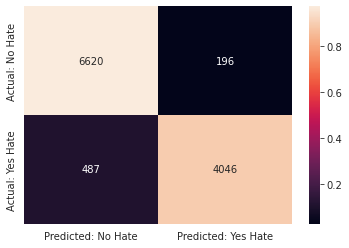

In [24]:
y_pred, test_prob, train_prob = train(LogisticRegression(solver='liblinear', C=0.1, tol=1e-05, multi_class='auto'),
                                      StandardScaler(),
                                      X_train, y_train, X_test)

train_auc = roc_auc_score(y_train, train_prob)
test_auc = roc_auc_score(y_test, test_prob)
print(f"Train ROC AUC Logistic Regression Score: {train_auc:.4f}")
print(f"Test ROC AUC Logistic Regression Score: {test_auc:.4f}")
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
plt.show()

#### Apply Cost-Sensitive Logistic Regression for Imbalanced Classification

Train ROC AUC Logistic Regression Score: 0.9833
Test ROC AUC Logistic Regression Score: 0.9785
'%' of Misclassified class: 6.018151378976121


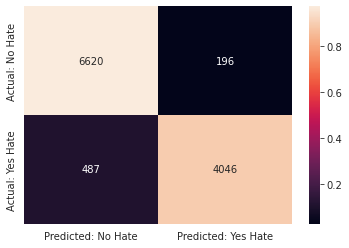

Train ROC AUC Logistic Regression Score: 0.9838
Test ROC AUC Logistic Regression Score: 0.9779
'%' of Misclassified class: 14.406555643669044


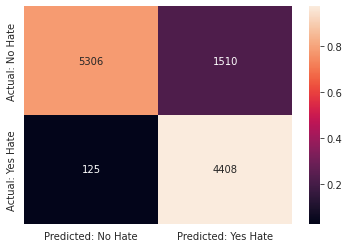

Train ROC AUC Logistic Regression Score: 0.9820
Test ROC AUC Logistic Regression Score: 0.9753
'%' of Misclassified class: 26.84818045642788


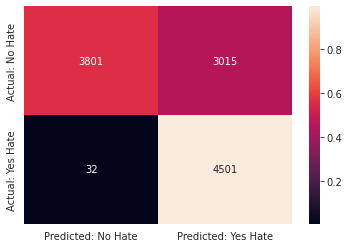

In [25]:
balance = [{0:1,1:1}, {0:1,1:10}, {0:1,1:100}]

for weight in balance:
    y_pred, test_prob, train_prob = train(LogisticRegression(solver='liblinear', C=0.1, tol=1e-05, multi_class='auto',
                                                             class_weight=weight),
                                          StandardScaler(),
                                          X_train, y_train, X_test)
    train_auc = roc_auc_score(y_train, train_prob)
    test_auc = roc_auc_score(y_test, test_prob)
    print(f"Train ROC AUC Logistic Regression Score: {train_auc:.4f}")
    print(f"Test ROC AUC Logistic Regression Score: {test_auc:.4f}")
    print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrix_plot(cm)
    plt.show()

Train ROC AUC Logistic Regression Score: 0.9833
Test ROC AUC Logistic Regression Score: 0.9785


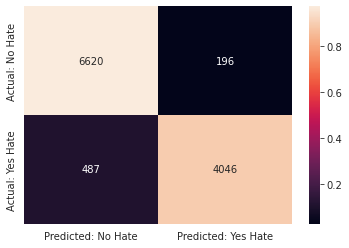

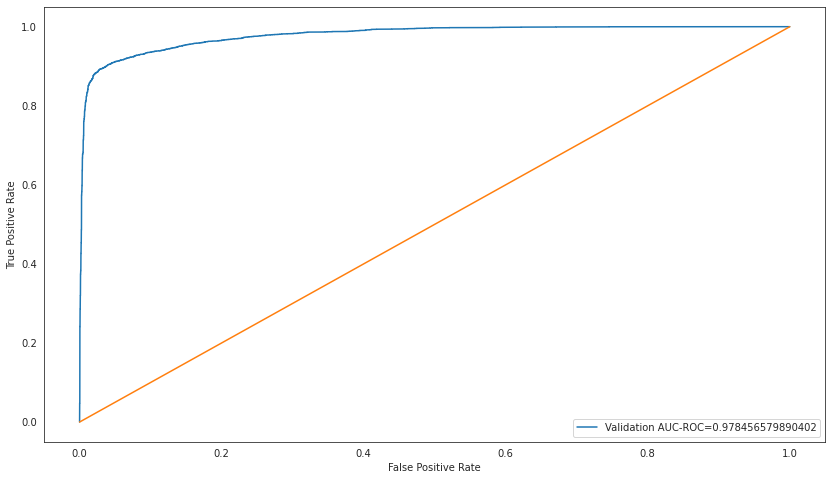

,Actual Label,Predicted_class
0,0,0
1,0,0
2,1,1
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,1,1


In [26]:
with mlflow.start_run(experiment_id=experiment_id, run_name='logreg-final'):
    mlflow.set_tags(tags)
    
    scaler=StandardScaler()
    solver='liblinear'
    C=0.1
    tol=1e-05
    multi_class='auto'
    class_weight={0:1,1:1}
    
    y_pred, test_prob, train_prob = train(LogisticRegression(solver=solver, C=C, tol=tol, multi_class=multi_class,
                                                             class_weight=class_weight),
                                          scaler,
                                          X_train, y_train, X_test)
    
    train_auc = roc_auc_score(y_train, train_prob)
    test_auc = roc_auc_score(y_test, test_prob)
    misclass = np.mean(y_pred != y_test)*100
    mlflow.log_param("scaler", scaler)
    mlflow.log_param("solver", solver)
    mlflow.log_param("C", C)
    mlflow.log_param("tol", tol)
    mlflow.log_param("multi_class", multi_class)
    mlflow.log_param("class_weight", class_weight)
    mlflow.log_param("percent-misclassified", misclass)
    mlflow.log_metrics({"train-auc-score":train_auc,
                        "test-auc-score":test_auc})

print(f"Train ROC AUC Logistic Regression Score: {train_auc:.4f}")
print(f"Test ROC AUC Logistic Regression Score: {test_auc:.4f}")
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, test_prob)
plt.show()

# compare the actual class and predicted class
out = pd.DataFrame(y_test[0:30])
out = out.rename(columns={0:'Actual Label'})
out['Predicted_class'] = y_pred[0:30]
out

## Random Forest & Parameter tuning

In [27]:
with mlflow.start_run():
    
    random_state=42
    for n in [5, 10, 50, 200, 250, 300, 350]:
        y_pred, test_prob, train_prob = train(RandomForestClassifier(n_estimators=n, random_state=random_state),
                                              StandardScaler(),
                                              X_train, y_train, X_test)
        train_auc = roc_auc_score(y_train, train_prob)
        test_auc = roc_auc_score(y_test, test_prob)
        with mlflow.start_run(experiment_id=experiment_id, run_name='randfort-tuning', nested=True):
            mlflow.set_tags(tags)
            mlflow.log_params({"random_state":random_state,
                             "n_estimators":n, "percent-misclassified":np.mean(y_pred != y_test)*100})
            mlflow.log_metrics({"train-auc-score":train_auc,
                                "test-auc-score":test_auc})
        print(f"{n}->{train_auc:.4f}")
        print(f"{n}->{test_auc:.4f}")

5->0.9991
5->0.9565
10->0.9999
10->0.9679
50->1.0000
50->0.9770
200->1.0000
200->0.9785
250->1.0000
250->0.9787
300->1.0000
300->0.9789
350->1.0000
350->0.9788


In [28]:
with mlflow.start_run():
    
    for m in [300, 350]:
        print(f"Number of estimators {m}")

        for c in ["gini", "entropy"]:
            y_pred, test_prob, train_prob = train(RandomForestClassifier(n_estimators=m, criterion=c, random_state=42),
                                                  StandardScaler(),
                                                  X_train, y_train, X_test)
            train_auc = roc_auc_score(y_train, train_prob)
            test_auc = roc_auc_score(y_test, test_prob)
            with mlflow.start_run(experiment_id=experiment_id, run_name='randfort-tuning', nested=True):
                mlflow.set_tags(tags)
                mlflow.log_params({"random_state":random_state,
                                 "n_estimators":m, "criterion":c,
                                  "percent-misclassified":np.mean(y_pred != y_test)*100})
                mlflow.log_metrics({"train-auc-score":train_auc,
                                    "test-auc-score":test_auc})
                
            print(f"{c}->{train_auc:.4f}")
            print(f"{c}->{test_auc:.4f}")
        print()

Number of estimators 300
gini->1.0000
gini->0.9789
entropy->1.0000
entropy->0.9789

Number of estimators 350
gini->1.0000
gini->0.9788
entropy->1.0000
entropy->0.9790



In [29]:
with mlflow.start_run():
    
    n_estimators=350
    for depth in [1, 2, 3, 4, 5]:
        y_pred, test_prob, train_prob = train(RandomForestClassifier(n_estimators=n_estimators, criterion='entropy', 
                                                                     max_depth=depth),
                                              StandardScaler(),
                                              X_train, y_train, X_test)
        train_auc = roc_auc_score(y_train, train_prob)
        test_auc = roc_auc_score(y_test, test_prob)
        with mlflow.start_run(experiment_id=experiment_id, run_name='randfort-tuning', nested=True):
            mlflow.set_tags(tags)
            mlflow.log_params({"random_state": random_state,
                               "n_estimators": n_estimators,
                               "criterion":'entropy',
                               "depth":depth,
                               "percent-misclassified":np.mean(y_pred != y_test)*100})
            mlflow.log_metrics({"train-auc-score":train_auc,
                                "test-auc-score":test_auc})
        print(f"{depth}->{train_auc:.4f}")
        print(f"{depth}->{test_auc:.4f}")

1->0.9236
1->0.9213
2->0.9363
2->0.9336
3->0.9391
3->0.9363
4->0.9398
4->0.9370
5->0.9430
5->0.9397


Train ROC AUC Random Forest Classifier Score: 1.0000
Test ROC AUC Random Forest Classifier Score: 0.9790
'%' of Misclassified class: 6.846418186624373


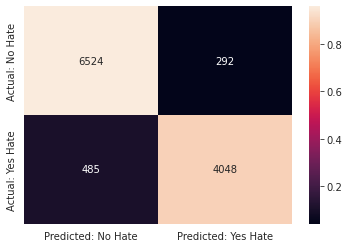

,Actual Label,Predicted_class
0,0,0
1,0,0
2,1,1
3,0,0
4,0,0
5,0,0
6,0,1
7,0,0
8,0,0
9,1,1


In [30]:
y_pred, test_prob, train_prob = train(RandomForestClassifier(n_estimators=300, criterion='entropy',
                                                             max_depth=None, class_weight={0:1,1:100}, random_state=42),
                                      StandardScaler(),
                                      X_train, y_train, X_test)

train_auc = roc_auc_score(y_train, train_prob)
test_auc = roc_auc_score(y_test, test_prob)
print(f"Train ROC AUC Random Forest Classifier Score: {train_auc:.4f}")
print(f"Test ROC AUC Random Forest Classifier Score: {test_auc:.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
plt.show()

# compare the actual class and predicted class
out = pd.DataFrame(y_test[0:30])
out = out.rename(columns={0:'Actual Label'})
out['Predicted_class'] = y_pred[0:30]
out

Train ROC AUC Random Forest Classifier Score: 1.0000
Test ROC AUC Random Forest Classifier Score: 0.9790
'%' of Misclassified class: 6.546832320028197


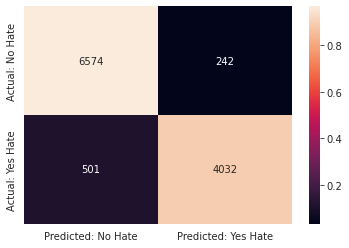

,Actual Label,Predicted_class
0,0,0
1,0,0
2,1,1
3,0,0
4,0,0
5,0,0
6,0,1
7,0,0
8,0,0
9,1,1


In [31]:
with mlflow.start_run(experiment_id=experiment_id, run_name='randfort-final'):
    mlflow.set_tags(tags)
    
    scaler=StandardScaler()
    n_estimators=350
    criterion='entropy'
    max_depth=None
    random_state=42
    
    y_pred, test_prob, train_prob = train(RandomForestClassifier(n_estimators=n_estimators, criterion=criterion,
                                                                 max_depth=max_depth, random_state=random_state),
                                          scaler,
                                          X_train, y_train, X_test)
    
    train_auc = roc_auc_score(y_train, train_prob)
    test_auc = roc_auc_score(y_test, test_prob)
    misclass = np.mean(y_pred != y_test)*100
    mlflow.log_param("scaler", scaler)
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("criterion", criterion)
    mlflow.log_param("max_depth", max_depth)
    mlflow.log_param("random_state", random_state)
    mlflow.log_param("percent-misclassified", misclass)
    mlflow.log_metrics({"train-auc-score":train_auc,
                        "test-auc-score":test_auc})

# auc = roc_auc_score(y_test, pred)
print(f"Train ROC AUC Random Forest Classifier Score: {train_auc:.4f}")
print(f"Test ROC AUC Random Forest Classifier Score: {test_auc:.4f}")
print("'%' of Misclassified class:", misclass)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
plt.show()

# compare the actual class and predicted class
out = pd.DataFrame(y_test[0:30])
out = out.rename(columns={0:'Actual Label'})
out['Predicted_class'] = y_pred[0:30]
out

In [32]:
with mlflow.start_run():
    
    objective= 'binary'
    for n in [25, 50, 100, 150, 200, 250, 300, 350, 400]:
        y_pred, test_pred, train_pred = train(lgb.LGBMClassifier(n_estimators=n, objective=objective),
                                              StandardScaler(),
                                              X_train, y_train, X_test)
        train_auc = roc_auc_score(y_train, train_pred)
        test_auc = roc_auc_score(y_test, test_pred)
        misclass = np.mean(y_pred != y_test)*100
        with mlflow.start_run(experiment_id=experiment_id, run_name='lgb-tuning-sklearn', nested=True):
            mlflow.set_tags(tags)
            mlflow.log_params({"objective":objective,
                              "n_estimators":n, "percent-misclassified":np.mean(y_pred != y_test)*100})
            mlflow.log_metrics({"train-auc-score":train_auc,
                                "test-auc-score":test_auc})
        print(f"{n}->{train_auc:.5f}")
        print(f"{n}->{test_auc:.5f}")

25->0.97222
25->0.97054
50->0.98096
50->0.97735
100->0.98811
100->0.98116
150->0.99119
150->0.98207
200->0.99302
200->0.98258
250->0.99444
250->0.98282
300->0.99554
300->0.98281
350->0.99646
350->0.98285
400->0.99717
400->0.98278


In [33]:
with mlflow.start_run():
    
    n_estimators=400
    objective='binary'
    for alpha in [0.001, 0.01, 0.1, 1, 1.5, 2, 2.5]:
        y_pred, test_pred, train_pred = train(lgb.LGBMClassifier(n_estimators=n_estimators,
                                                                 objective=objective,
                                                                 reg_alpha=alpha),
                                              StandardScaler(),
                                              X_train, y_train, X_test)
        train_auc = roc_auc_score(y_train, train_pred)
        test_auc = roc_auc_score(y_test, test_pred)
        with mlflow.start_run(experiment_id=experiment_id, run_name='lgb-tuning-sklearn', nested=True):
            mlflow.set_tags(tags)
            mlflow.log_params({"objective":objective,
                               "n_estimators":n_estimators,"reg-alpha":alpha,
                               "percent-misclassified":np.mean(y_pred != y_test)*100})
            mlflow.log_metrics({"train-auc-score":train_auc,
                                "test-auc-score":test_auc})
        print(f"{alpha}->{train_auc:.4f}")
        print(f"{alpha}->{test_auc:.4f}")

0.001->0.9971
0.001->0.9829
0.01->0.9971
0.01->0.9829
0.1->0.9971
0.1->0.9831
1->0.9963
1->0.9827
1.5->0.9958
1.5->0.9822
2->0.9954
2->0.9826
2.5->0.9950
2.5->0.9821


In [34]:
with mlflow.start_run():
    
    n_estimators=400
    objective='binary'
    alpha=0.1

    for lr in [0.001, 0.01, 0.1, 1, 1.5, 2, 2.5]:
        y_pred, test_pred, train_pred = train(lgb.LGBMClassifier(n_estimators=n_estimators, objective=objective, 
                                                                 reg_alpha=alpha, learning_rate=lr),
                                              StandardScaler(),
                                              X_train, y_train, X_test)
        train_auc = roc_auc_score(y_train, train_pred)
        test_auc = roc_auc_score(y_test, test_pred)
        with mlflow.start_run(nested=True):
            mlflow.set_tags(tags)
            mlflow.log_params({"objective":objective,"n_estimators":n_estimators,"reg-alpha":alpha,
                             "learning-rate":lr,"percent-misclassified":np.mean(y_pred != y_test)*100})
            mlflow.log_metrics({"train-auc-score":train_auc,
                                "test-auc-score":test_auc})
        print(f"{lr}->{train_auc:.4f}")
        print(f"{lr}->{test_auc:.4f}")

0.001->0.9600
0.001->0.9594
0.01->0.9784
0.01->0.9755
0.1->0.9971
0.1->0.9831
1->0.6113
1->0.6039
1.5->0.7599
1.5->0.7520
2->0.6659
2->0.6635
2.5->0.5682
2.5->0.5717


ROC AUC LGBM Classifier Score: 0.9831


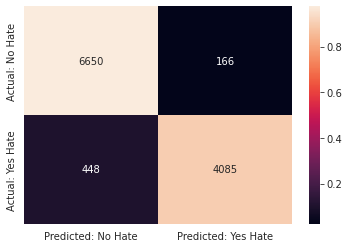

In [35]:
y_pred, test_pred, train_pred = train(lgb.LGBMClassifier(n_estimators=400, reg_alpha=0.1, learning_rate=0.1, objective='binary'),
                                      StandardScaler(),
                                      X_train, y_train, X_test)
auc = roc_auc_score(y_test, test_pred)
print(f"ROC AUC LGBM Classifier Score: {auc:.4f}")
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
plt.show()

ROC AUC LGBM Classifier Score: 0.9831
'%' of Misclassified class: 5.410168296766235


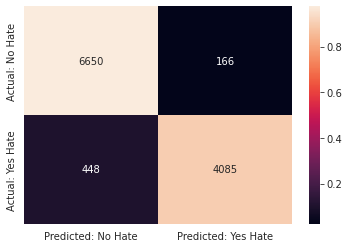

ROC AUC LGBM Classifier Score: 0.9829
'%' of Misclassified class: 9.718917966340648


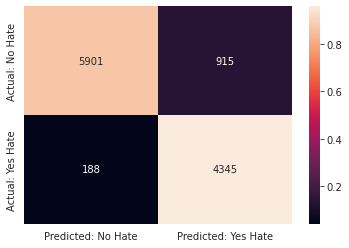

ROC AUC LGBM Classifier Score: 0.9797
'%' of Misclassified class: 17.29667812142039


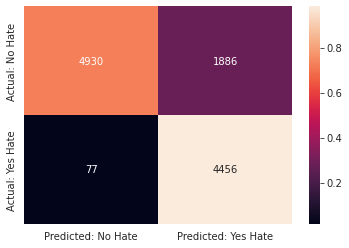

In [36]:
balance = [{0:1,1:1}, {0:1,1:10}, {0:1,1:100}]

for weight in balance:
    y_pred, test_pred, train_pred = train(lgb.LGBMClassifier(n_estimators=400, reg_alpha=0.1, 
                                                             learning_rate=0.1, objective='binary',
                                                             class_weight=weight),
                                          StandardScaler(),
                                          X_train, y_train, X_test)
    auc = roc_auc_score(y_test, test_pred)
    print(f"ROC AUC LGBM Classifier Score: {auc:.4f}")
    print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrix_plot(cm)
    plt.show()

ROC AUC LGBM Classifier Score: 0.9831
'%' of Misclassified class: 5.410168296766235


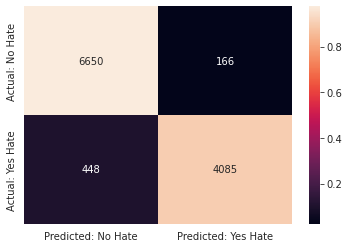

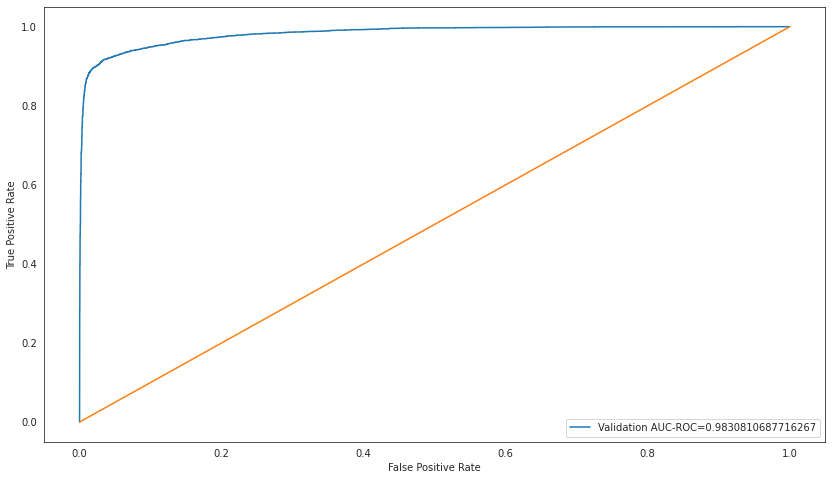

In [37]:
y_pred, test_pred, train_pred = train(lgb.LGBMClassifier(n_estimators=400, reg_alpha=0.1, learning_rate=0.1, 
                                                         objective='binary',
                                                         class_weight={0:1,1:1}),
                                      StandardScaler(),
                                      X_train, y_train, X_test)
auc = roc_auc_score(y_test, test_pred)
print(f"ROC AUC LGBM Classifier Score: {auc:.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, test_pred)
plt.show()

## XGBoost Classifier & Parameter tuning

In [35]:
# trainD = xgb.DMatrix(X_train, label=y_train)
# validD = xgb.DMatrix(X_test, label=y_test)

In [70]:
# def objective(params):
    
#     with mlflow.start_run():
#         mlflow.set_tag("developer", "daniel")
#         mlflow.log_param("train-data1-path", os.path.join(config.DATAPATH, 'train.csv'))
#         mlflow.log_param("train-data2-path", os.path.join(config.DATAPATH, 'HateSpeechData.csv'))
#         mlflow.set_tag("model", "xgboost")
#         mlflow.log_params(params)
#         xgb_model = xgb.train(
#             params=params,
#             dtrain=trainD,
#             num_boost_round=500,
#             evals= [(trainD, 'train'), (validD, 'val')],
#             early_stopping_rounds=50)
        
#         test_pred = xgb_model.predict(validD)
#         train_pred = xgb_model.predict(trainD)
        
#         train_pred = binary_predict(train_pred)
#         test_pred = binary_predict(test_pred)

#         train_auc = roc_auc_score(y_train, train_pred)
#         test_auc = roc_auc_score(y_test, test_pred)
# #         auc = roc_auc_score(y_test, y_pred)
#         misclass = np.mean(test_pred != y_test)*100
        
#         mlflow.log_param("percent-misclassified",misclass)
#         mlflow.log_metrics({"train-auc-score":train_auc})
#         mlflow.log_metrics({"test-auc-score":test_auc})
    
#     return {'loss':test_auc, 'status':STATUS_OK}

# search_space = {
#     "max_depth":scope.int(hp.quniform("max_depth", 4, 100, 1)),
# #     "learning_rate":hp.loguniform("learning_rate", -15, -1), # exponential(-7) and exponential(0)
#     'eta': hp.loguniform("eta", -9, 0),
#     "reg_alpha":hp.loguniform("reg_alpha", -15, -2),
#     "reg_lambda":hp.loguniform("reg_lambda", -15, -2),
#     "min_child_weight":hp.loguniform("min_child_weight", -9, -2),
#     "objective":"binary:logistic",
# #     "eval_metric":"auc",
#     "seed":43
# }

# best_result = fmin(
#     fn=objective,
#     space=search_space,
#     algo=tpe.suggest,
#     max_evals=5,
#     trials=Trials()
# )

[20:11:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.69156	val-logloss:0.69176                                                                           
[1]	train-logloss:0.69002	val-logloss:0.69037                                                                           
[2]	train-logloss:0.68847	val-logloss:0.68899                                                                           
[3]	train-logloss:0.68694	val-logloss:0.68761                                                                           
[4]	train-logloss:0.68537	val-logloss:0.68624                                                                           
[5]	train-logloss:0.68383	val-logloss:0.68488                                                                           
[6]	train-logloss:0.68

[132]	train-logloss:0.52202	val-logloss:0.54298                                                                         
[133]	train-logloss:0.52098	val-logloss:0.54207                                                                         
[134]	train-logloss:0.51992	val-logloss:0.54116                                                                         
[135]	train-logloss:0.51888	val-logloss:0.54026                                                                         
[136]	train-logloss:0.51784	val-logloss:0.53936                                                                         
[137]	train-logloss:0.51681	val-logloss:0.53847                                                                         
[138]	train-logloss:0.51575	val-logloss:0.53757                                                                         
[139]	train-logloss:0.51473	val-logloss:0.53667                                                                         
[140]	train-logloss:0.51367	val-

[266]	train-logloss:0.40283	val-logloss:0.44184                                                                         
[267]	train-logloss:0.40208	val-logloss:0.44122                                                                         
[268]	train-logloss:0.40133	val-logloss:0.44060                                                                         
[269]	train-logloss:0.40058	val-logloss:0.43998                                                                         
[270]	train-logloss:0.39984	val-logloss:0.43936                                                                         
[271]	train-logloss:0.39908	val-logloss:0.43875                                                                         
[272]	train-logloss:0.39834	val-logloss:0.43813                                                                         
[273]	train-logloss:0.39760	val-logloss:0.43751                                                                         
[274]	train-logloss:0.39685	val-

[98]	train-logloss:0.57571	val-logloss:0.57729                                                                          
[99]	train-logloss:0.57472	val-logloss:0.57630                                                                          
[100]	train-logloss:0.57372	val-logloss:0.57531                                                                         
[101]	train-logloss:0.57270	val-logloss:0.57433                                                                         
[102]	train-logloss:0.57172	val-logloss:0.57335                                                                         
[103]	train-logloss:0.57073	val-logloss:0.57236                                                                         
[104]	train-logloss:0.56976	val-logloss:0.57139                                                                         
[105]	train-logloss:0.56877	val-logloss:0.57042                                                                         
[106]	train-logloss:0.56780	val-

[232]	train-logloss:0.46639	val-logloss:0.46963                                                                         
[233]	train-logloss:0.46572	val-logloss:0.46898                                                                         
[234]	train-logloss:0.46508	val-logloss:0.46834                                                                         
[235]	train-logloss:0.46441	val-logloss:0.46769                                                                         
[236]	train-logloss:0.46374	val-logloss:0.46704                                                                         
[237]	train-logloss:0.46310	val-logloss:0.46640                                                                         
[238]	train-logloss:0.46245	val-logloss:0.46576                                                                         
[239]	train-logloss:0.46178	val-logloss:0.46511                                                                         
[240]	train-logloss:0.46114	val-

[64]	train-logloss:0.67274	val-logloss:0.67302                                                                          
[65]	train-logloss:0.67239	val-logloss:0.67272                                                                          
[66]	train-logloss:0.67211	val-logloss:0.67243                                                                          
[67]	train-logloss:0.67178	val-logloss:0.67212                                                                          
[68]	train-logloss:0.67149	val-logloss:0.67182                                                                          
[69]	train-logloss:0.67120	val-logloss:0.67153                                                                          
[70]	train-logloss:0.67085	val-logloss:0.67123                                                                          
[71]	train-logloss:0.67060	val-logloss:0.67092                                                                          
[72]	train-logloss:0.67026	val-l

[198]	train-logloss:0.63395	val-logloss:0.63488                                                                         
[199]	train-logloss:0.63370	val-logloss:0.63461                                                                         
[200]	train-logloss:0.63345	val-logloss:0.63435                                                                         
[201]	train-logloss:0.63311	val-logloss:0.63408                                                                         
[202]	train-logloss:0.63288	val-logloss:0.63381                                                                         
[203]	train-logloss:0.63260	val-logloss:0.63355                                                                         
[204]	train-logloss:0.63231	val-logloss:0.63327                                                                         
[205]	train-logloss:0.63204	val-logloss:0.63300                                                                         
[206]	train-logloss:0.63180	val-

[30]	train-logloss:0.03241	val-logloss:0.20437                                                                          
[31]	train-logloss:0.02947	val-logloss:0.20484                                                                          
[32]	train-logloss:0.02682	val-logloss:0.20568                                                                          
[33]	train-logloss:0.02452	val-logloss:0.20658                                                                          
[34]	train-logloss:0.02238	val-logloss:0.20774                                                                          
[35]	train-logloss:0.02054	val-logloss:0.20902                                                                          
[36]	train-logloss:0.01874	val-logloss:0.21065                                                                          
[37]	train-logloss:0.01707	val-logloss:0.21254                                                                          
[38]	train-logloss:0.01559	val-l

[83]	train-logloss:0.65217	val-logloss:0.65269                                                                          
[84]	train-logloss:0.65172	val-logloss:0.65225                                                                          
[85]	train-logloss:0.65122	val-logloss:0.65179                                                                          
[86]	train-logloss:0.65077	val-logloss:0.65133                                                                          
[87]	train-logloss:0.65032	val-logloss:0.65089                                                                          
[88]	train-logloss:0.64987	val-logloss:0.65044                                                                          
[89]	train-logloss:0.64943	val-logloss:0.64998                                                                          
[90]	train-logloss:0.64897	val-logloss:0.64954                                                                          
[91]	train-logloss:0.64848	val-l

[217]	train-logloss:0.59553	val-logloss:0.59688                                                                         
[218]	train-logloss:0.59512	val-logloss:0.59650                                                                         
[219]	train-logloss:0.59474	val-logloss:0.59612                                                                         
[220]	train-logloss:0.59434	val-logloss:0.59574                                                                         
[221]	train-logloss:0.59401	val-logloss:0.59537                                                                         
[222]	train-logloss:0.59363	val-logloss:0.59498                                                                         
[223]	train-logloss:0.59323	val-logloss:0.59461                                                                         
[224]	train-logloss:0.59282	val-logloss:0.59422                                                                         
[225]	train-logloss:0.59242	val-

In [54]:
# for n in [200, 250, 300, 350]:
#     pred, y_pred = train(xgb.XGBClassifier(n_estimators=n, eval_metric="auc", 
#                                        objective='binary:logistic'),
#                          StandardScaler(),
#                          X_train, y_train, X_test)
#     auc = roc_auc_score(y_test, pred)
#     print(f"{n}->{auc:.4f}")

In [55]:
# for lr in [0.0001, 0.001, 0.1, 1, 1.5]:
#     pred, y_pred = train(xgb.XGBClassifier(n_estimators=350, eval_metric="auc", 
#                                        objective='binary:logistic', learning_rate=lr),
#                          StandardScaler(),
#                          X_train, y_train, X_test)
#     auc = roc_auc_score(y_test, pred)
#     print(f"{lr}->{auc:.4f}")

In [56]:
# pred, y_pred = train(xgb.XGBClassifier(n_estimators=350, eval_metric="auc", 
#                                     objective='binary:logistic'),
#                      StandardScaler(),
#                      X_train, y_train, X_test)
# auc = roc_auc_score(y_test, pred)
# print(f"ROC AUC XGBoost Classifier Score: {auc:.4f}")
# cm = confusion_matrix(y_test, y_pred)
# confusion_matrix_plot(cm)
# roc_auc_curve(y_test, pred)
# plt.show()

The LGBM Model has the best performance. We will use cross validation to prevent overfitting and check so we know the actual scores of individual model.

# Model Evaluation with Cross Validation

In [38]:
def cross_validation_score(ml_model, scaler, thres = 0.5, random_st=42, cols = data_cleaned.columns):
    
    """
    Function to calculate the k fold cross validation stratified on the basis of target
    and prints the ROC, Recall and Precision Scores.
    
    Args:
        ml_model (numpy array) : ml_model for predictions
        thres (float) : threshold for the probabilities of the model predictions
        random_st (int) : random_st is the random state for Kfold
        cols (string) : cols are the column names
    
    Returns:
        cv_scores (float) : cross validation scores
    """
    
    i= 1
    x1 = data_cleaned.copy()
    x1 = data_cleaned[cols]
    cv_scores = []
    
    sKf = StratifiedKFold(n_splits= 5, shuffle= True, random_state= random_st)
    
    for train_index, test_index in sKf.split(x1, y):
        print(f"\n{i} of KFold {sKf.n_splits}")
        xtrain, xval = x1.iloc[train_index], x1.iloc[test_index]
        ytrain, yval = y.iloc[train_index], y.iloc[test_index]
        
        model = ml_model
        pipeline = make_pipeline(scaler, model)
        pipeline.fit(xtrain, ytrain)
        y_pred = pipeline.predict(xval)
        pred_probs = pipeline.predict_proba(xval)
        pp = []
        
        # Use threshold to define the classes based on probability values
        for j in pred_probs[:,1]:
            if j > thres:
                pp.append(1)
            else:
                pp.append(0)
        # Calculate scores for each fold
        pred_val = pp
        roc_score = roc_auc_score(yval, pred_probs[:,1])
        recall = recall_score(yval, pred_val)
        precision = precision_score(yval, pred_val)
        msg = ""
        msg += f"ROC AUC Score: {roc_score:.4f}, Recall Score: {recall:.4f}, Precision Score: {precision:.4f}"
        print(f"{msg}")
        cv_scores.append(roc_score)
        i+=1
        
    return cv_scores

## Multinomial NB

In [39]:
y=target_labelled_data
nb_cv_score = cross_validation_score(MultinomialNB(alpha=10), MinMaxScaler())


1 of KFold 5
ROC AUC Score: 0.9619, Recall Score: 0.8841, Precision Score: 0.8821

2 of KFold 5
ROC AUC Score: 0.9633, Recall Score: 0.8841, Precision Score: 0.8921

3 of KFold 5
ROC AUC Score: 0.9652, Recall Score: 0.8948, Precision Score: 0.8870

4 of KFold 5
ROC AUC Score: 0.9660, Recall Score: 0.9025, Precision Score: 0.8889

5 of KFold 5
ROC AUC Score: 0.9608, Recall Score: 0.8769, Precision Score: 0.8777


## Logistic Regression

In [59]:
log_cv_score = cross_validation_score(LogisticRegression(solver='liblinear', 
                                                         C=0.1, tol=1e-05, 
                                                         multi_class='auto',
                                                         class_weight={0:1,1:1}),
                                      StandardScaler())


1 of KFold 5
ROC AUC Score: 0.9773, Recall Score: 0.8845, Precision Score: 0.9513

2 of KFold 5
ROC AUC Score: 0.9778, Recall Score: 0.8928, Precision Score: 0.9524

3 of KFold 5
ROC AUC Score: 0.9794, Recall Score: 0.8983, Precision Score: 0.9538

4 of KFold 5
ROC AUC Score: 0.9793, Recall Score: 0.8959, Precision Score: 0.9504

5 of KFold 5
ROC AUC Score: 0.9760, Recall Score: 0.8863, Precision Score: 0.9532


## RandomForestClassifier

In [60]:
rf_cv_score = cross_validation_score(RandomForestClassifier(n_estimators=350, criterion='entropy',
                                                            max_depth=None, random_state=42),
                                     StandardScaler())


1 of KFold 5
ROC AUC Score: 0.9772, Recall Score: 0.8882, Precision Score: 0.9471

2 of KFold 5
ROC AUC Score: 0.9795, Recall Score: 0.8909, Precision Score: 0.9485

3 of KFold 5
ROC AUC Score: 0.9821, Recall Score: 0.8983, Precision Score: 0.9520

4 of KFold 5
ROC AUC Score: 0.9803, Recall Score: 0.8953, Precision Score: 0.9508

5 of KFold 5
ROC AUC Score: 0.9768, Recall Score: 0.8885, Precision Score: 0.9504


## LGBM Model

In [61]:
lgm_cv_score = cross_validation_score(lgb.LGBMClassifier(n_estimators=400, 
                                                     reg_alpha=0.1,
                                                     learning_rate=0.1,
                                                     objective='binary',
                                                     class_weight={0:1,1:1}),
                                      StandardScaler())


1 of KFold 5
ROC AUC Score: 0.9820, Recall Score: 0.8926, Precision Score: 0.9607

2 of KFold 5
ROC AUC Score: 0.9825, Recall Score: 0.8983, Precision Score: 0.9571

3 of KFold 5
ROC AUC Score: 0.9850, Recall Score: 0.9064, Precision Score: 0.9669

4 of KFold 5
ROC AUC Score: 0.9842, Recall Score: 0.9031, Precision Score: 0.9638

5 of KFold 5
ROC AUC Score: 0.9820, Recall Score: 0.8948, Precision Score: 0.9674


## XGBClassifier

In [62]:
xgb_cv_score = cross_validation_score(xgb.XGBClassifier(n_estimators=350, eval_metric="auc", 
                                                    objective='binary:logistic'),
                                      StandardScaler())


1 of KFold 5
ROC AUC Score: 0.9811, Recall Score: 0.8917, Precision Score: 0.9609

2 of KFold 5
ROC AUC Score: 0.9821, Recall Score: 0.8987, Precision Score: 0.9618

3 of KFold 5
ROC AUC Score: 0.9842, Recall Score: 0.9027, Precision Score: 0.9661

4 of KFold 5
ROC AUC Score: 0.9841, Recall Score: 0.9018, Precision Score: 0.9647

5 of KFold 5
ROC AUC Score: 0.9815, Recall Score: 0.8944, Precision Score: 0.9658


# Comparison of Model Fold wise

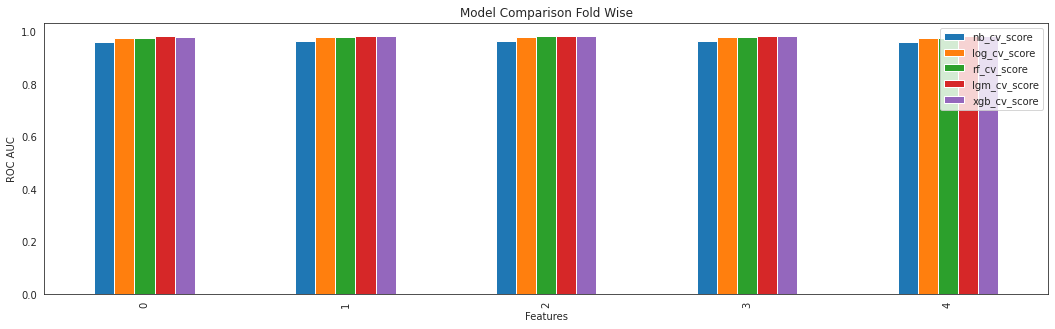

In [63]:
compare_score = pd.DataFrame({'nb_cv_score':nb_cv_score,
                              'log_cv_score':log_cv_score,
                              'rf_cv_score':rf_cv_score,
                              'lgm_cv_score':lgm_cv_score,
                              'xgb_cv_score':xgb_cv_score
                             })

compare_score.plot(y = ['nb_cv_score','log_cv_score','rf_cv_score',
                        'lgm_cv_score','xgb_cv_score'], 
                   kind = 'bar')

plt.title('Model Comparison Fold Wise')
plt.xlabel('Features')
plt.ylabel('ROC AUC');

**The `LGBM Model` has the best performance across 5-fold. Therefore, we will work on improving it.**

In [49]:
lgb_model = make_pipeline(StandardScaler(), lgb.LGBMClassifier(n_estimators=400, reg_alpha=0.1, learning_rate=0.1,
                                                           objective='binary',
                                                           class_weight={0:1,1:1}))

lgb_model.fit(X_train, y_train)

step_factor = 0.02
threshold_value = 0.1
roc_score = 0
proba = lgb_model.predict_proba(X_test)

# Continue to check for optimal value when threshold is
# less than 0.8
while threshold_value <= 0.8:
    temp_thresh = threshold_value
    predicted = (proba[:,1] >= temp_thresh).astype('int')
    print(f"Threshold: {temp_thresh}->{roc_auc_score(y_test, predicted)}")
    #store the threshold for best classification
    if roc_score < roc_auc_score(y_test, predicted):
        roc_score = roc_auc_score(y_test, predicted)
        threshold_score = threshold_value
    threshold_value = threshold_value + step_factor
print(f'\n---Optimum Threshold: {threshold_score}->ROC: {roc_score}')

Threshold: 0.1->0.8939630988556532
Threshold: 0.12000000000000001->0.9066110067641676
Threshold: 0.14->0.9141956928533477
Threshold: 0.16->0.919325863076096
Threshold: 0.18->0.9236121629956221
Threshold: 0.19999999999999998->0.9269817698380888
Threshold: 0.21999999999999997->0.9282952499355276
Threshold: 0.23999999999999996->0.9301618432745157
Threshold: 0.25999999999999995->0.932432166071656
Threshold: 0.27999999999999997->0.9345557752537728
Threshold: 0.3->0.9361294753963889
Threshold: 0.32->0.9372625006602597
Threshold: 0.34->0.9388736802571439
Threshold: 0.36000000000000004->0.9393839737076772
Threshold: 0.38000000000000006->0.9390118493333707
Threshold: 0.4000000000000001->0.9391558927800201
Threshold: 0.4200000000000001->0.9387848364730631
Threshold: 0.4400000000000001->0.9379361598667674
Threshold: 0.46000000000000013->0.9377492966291019
Threshold: 0.48000000000000015->0.9372690061613893
Threshold: 0.5000000000000001->0.9374494609949572
Threshold: 0.5200000000000001->0.937630449

In [50]:
cross_validation_score(lgb.LGBMClassifier(n_estimators=400, reg_alpha=0.1, learning_rate=0.1,
                                      objective='binary',
                                      class_weight={0:1,1:1}),
                       StandardScaler(), thres=0.36)


1 of KFold 5
ROC AUC Score: 0.9815, Recall Score: 0.9084, Precision Score: 0.9390

2 of KFold 5
ROC AUC Score: 0.9828, Recall Score: 0.9147, Precision Score: 0.9370

3 of KFold 5
ROC AUC Score: 0.9849, Recall Score: 0.9217, Precision Score: 0.9446

4 of KFold 5
ROC AUC Score: 0.9840, Recall Score: 0.9171, Precision Score: 0.9385

5 of KFold 5
ROC AUC Score: 0.9813, Recall Score: 0.9079, Precision Score: 0.9473


[0.9815020724593283,
 0.9827641896688544,
 0.9848852540326365,
 0.9839785187478168,
 0.9813013656720792]

There is no improvement in the recall score. There was no improvement in the recall till after we gathered more data which improved the roc across all model.

**Ways to improve this model**
1. Add more training data
2. Try Over/Undersampling techniques like SMOTE

**My approach to Semi-Supervised Learning**

1. Select the best model after Supervised learning which is the LGBM Model
2. Try to improve the model with different SMOTE techniques
3. Select the SMOTE with low '%' of Misclassification & high ROC
4. Train model with SMOTE training data if the '%' of Misclassification is lower than the original training data
5. Perform Pseudo Labelling on with the best model
6. Select a better confidence/probability value via the graph with the new training data.
7. Training the model with the new training data based on the confidence.
8. Do step 2,3,4 and 5.
9. Store model for deployment.

# Addressing Imbalanced Class with SMOTE on LGBMClassifier for Semi-supervised Learning

In [64]:
print(X_train.shape)
print(y_train.shape)
print()
print(Counter(y_train))

(45396, 1018)
(45396,)

Counter({0: 27067, 1: 18329})


In [19]:
X_train_ada, y_train_ada = ADASYN(random_state = 154).fit_resample(X_train, y_train)
print(X_train_ada.shape)
print(y_train_ada.shape)
print(Counter(y_train_ada))

(54451, 1018)
(54451,)
Counter({1: 27384, 0: 27067})


'%' of Misclassified class: 5.30443210855582


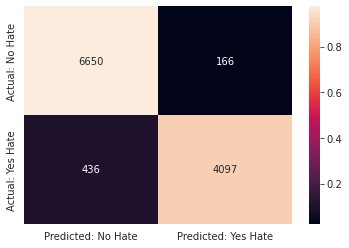

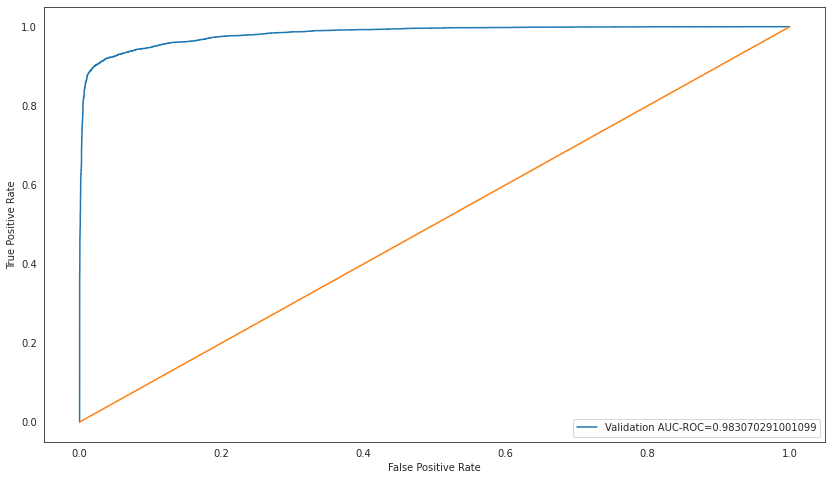

,Actual Label,Predicted_class
0,0,0
1,0,0
2,1,1
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,1,1


In [21]:
with mlflow.start_run(experiment_id=experiment_id, run_name='lgb-tuning-sklearn-ada'):
    mlflow.set_tags(tags)
    
    n_estimators=400
    objective='binary'
    alpha=0.1
    lr=0.1
    balance={0:1,1:1}
    
    y_pred, test_pred, train_pred = train(lgb.LGBMClassifier(n_estimators=n_estimators, objective=objective, 
                                                             reg_alpha=alpha, learning_rate=lr, class_weight=balance),
                                          StandardScaler(),
                                          X_train_ada, y_train_ada, X_test)
    
    train_auc = roc_auc_score(y_train_ada, train_pred)
    test_auc = roc_auc_score(y_test, test_pred)
    misclass = np.mean(y_pred != y_test)*100
    
    mlflow.log_params({"objective":objective,"SMOTE":'ada',
                     "n_estimators":n_estimators,"reg-alpha":alpha,"learning_rate":lr,
                     "class_weight":balance,
                     "percent-misclassified":misclass})
    mlflow.log_metrics({"train-auc-score":train_auc,
                        "test-auc-score":test_auc})
    
print("'%' of Misclassified class:", misclass)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, test_pred)
plt.show()

out = pd.DataFrame(y_test[0:30])
out = out.rename(columns={0:'Actual Label'})
out['Predicted_class'] = y_pred[0:30]
out

(54134, 1018)
(54134,)
Counter({0: 27067, 1: 27067})
'%' of Misclassified class: 5.295620759538285


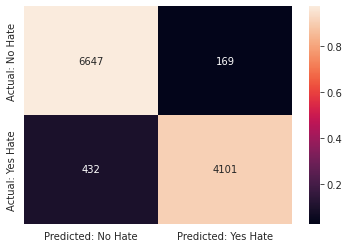

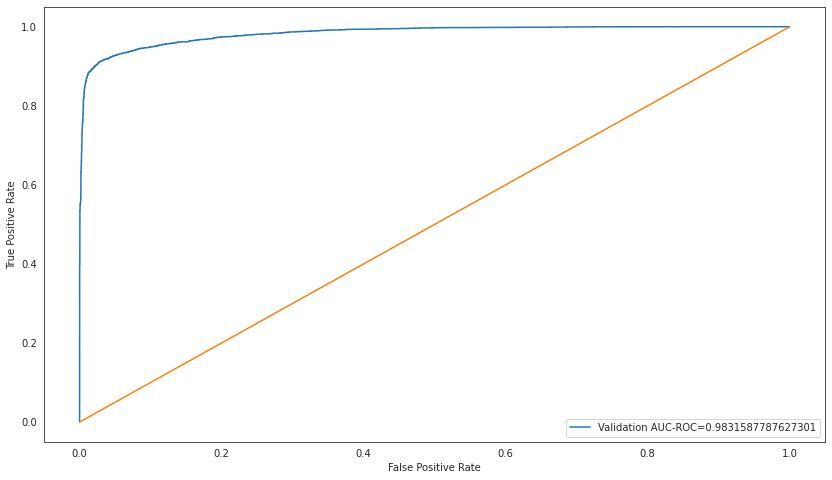

,Actual Label,Predicted_class
0,0,0
1,0,0
2,1,1
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,1,1


In [22]:
X_train_bls, y_train_bls = BorderlineSMOTE(random_state = 154).fit_resample(X_train, y_train)
print(X_train_bls.shape)
print(y_train_bls.shape)
print(Counter(y_train_bls))

with mlflow.start_run(experiment_id=experiment_id, run_name='lgb-tuning-sklearn-bls'):
    mlflow.set_tags(tags)
    
    n_estimators=400
    objective='binary'
    alpha=0.1
    lr=0.1
    balance={0:1,1:1}
    
    y_pred, test_pred, train_pred = train(lgb.LGBMClassifier(n_estimators=n_estimators, objective=objective, 
                                                             reg_alpha=alpha, learning_rate=lr, class_weight=balance),
                                          StandardScaler(),
                                          X_train_bls, y_train_bls, X_test)
    
    train_auc = roc_auc_score(y_train_bls, train_pred)
    test_auc = roc_auc_score(y_test, test_pred)
    misclass = np.mean(y_pred != y_test)*100
    
    mlflow.log_params({"objective":objective,"SMOTE":'bls',"n_estimators":n_estimators,
                       "reg-alpha":alpha,"learning_rate":lr,"class_weight":balance,
                       "percent-misclassified":np.mean(y_pred != y_test)*100})
    mlflow.log_metrics({"train-auc-score":train_auc,
                        "test-auc-score":test_auc})
    
print("'%' of Misclassified class:", misclass)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, test_pred)
plt.show()

out = pd.DataFrame(y_test[0:30])
out = out.rename(columns={0:'Actual Label'})
out['Predicted_class'] = y_pred[0:30]
out

In [23]:
smote_pipe = Pipeline([('over', SMOTE(random_state = 11, sampling_strategy=0.8)),
                     ('under', RandomUnderSampler(sampling_strategy=0.9))]
                   )

X_train_sm, y_train_sm = smote_pipe.fit_resample(X_train, y_train)
print(X_train_sm.shape)
print(y_train_sm.shape)
print()
print(Counter(y_train_sm))

(45711, 1018)
(45711,)

Counter({0: 24058, 1: 21653})


'%' of Misclassified class: 5.392545598731166


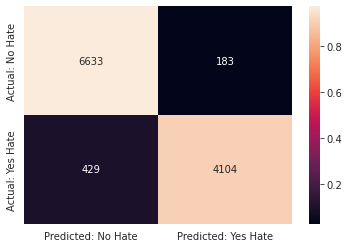

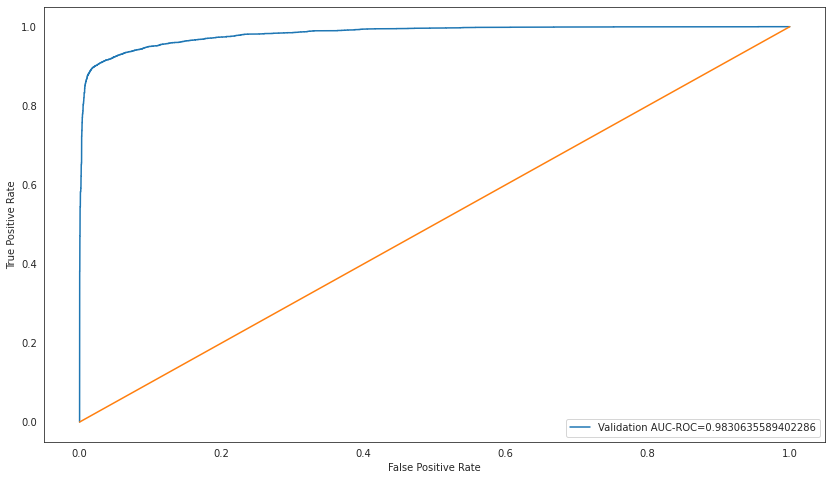

,Actual Label,Predicted_class
0,0,0
1,0,0
2,1,1
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,1,1


In [24]:
with mlflow.start_run(experiment_id=experiment_id, run_name='lgb-tuning-sklearn-sm'):
    mlflow.set_tags(tags)
    
    n_estimators=400
    objective='binary'
    alpha=0.1
    lr=0.1
    balance={0:1,1:1}
    
    y_pred, test_pred, train_pred = train(lgb.LGBMClassifier(n_estimators=n_estimators, objective=objective, 
                                                             reg_alpha=alpha, learning_rate=lr, class_weight=balance),
                                          StandardScaler(),
                                          X_train_sm, y_train_sm, X_test)
    
    train_auc = roc_auc_score(y_train_sm, train_pred)
    test_auc = roc_auc_score(y_test, test_pred)
    misclass = np.mean(y_pred != y_test)*100
    
    mlflow.log_param("objective", objective)
    mlflow.log_param("SMOTE", 'sm')
    mlflow.log_param("n_estimators",n_estimators)
    mlflow.log_params({"reg-alpha":alpha})
    mlflow.log_params({"learning_rate":lr})
    mlflow.log_params({"class_weight":balance})
    mlflow.log_params({"percent-misclassified":np.mean(y_pred != y_test)*100})
    mlflow.log_metrics({"train-auc-score":train_auc})
    mlflow.log_metrics({"test-auc-score":test_auc})
    
print("'%' of Misclassified class:", misclass)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, test_pred)
plt.show()

out = pd.DataFrame(y_test[0:30])
out = out.rename(columns={0:'Actual Label'})
out['Predicted_class'] = y_pred[0:30]
out

**We will train the model for psuedo-model with the BorderlineSmote data, because of the low '%' of Misclassified class though the roc score came down a bit. For imbalance problem accuracy/roc score is not essential as compared to the '%' of Misclassified class.**

# Semi-Supervised Learning

**Goal:** Is to develop a Pseudo-labeling approach to label tweets as hate or non-hate which is a Semi-Supervised Learning classification task.

ROC AUC LGBClassifer Score before Semi-Supervised Learning: 0.9832
'%' of Misclassified class: 5.295620759538285


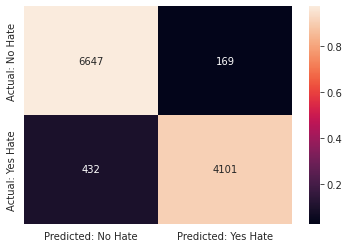

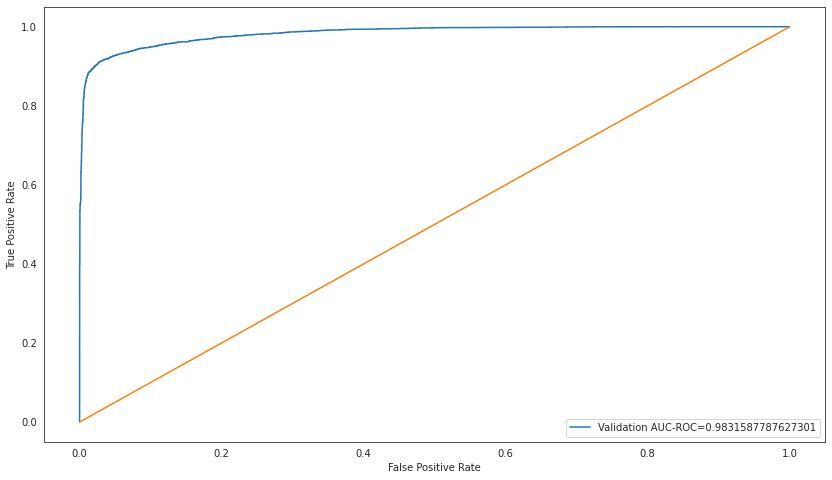

In [25]:
semi_sup_model = make_pipeline(StandardScaler(), lgb.LGBMClassifier(n_estimators=400, reg_alpha=0.1, learning_rate=0.1,
                                                                    objective='binary',
                                                                    class_weight={0:1,1:1}))
semi_sup_model.fit(X_train_bls, y_train_bls)
pred = semi_sup_model.predict_proba(X_test)[:, 1]
y_pred = semi_sup_model.predict(X_test)
auc = roc_auc_score(y_test, pred)
print(f"ROC AUC LGBClassifer Score before Semi-Supervised Learning: {auc:.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, pred)
plt.show()

In [26]:
unlabelled_cleaned = unlabelled_cleaned.values
probs = semi_sup_model.predict_proba(unlabelled_cleaned)
preds = semi_sup_model.predict(unlabelled_cleaned)

df_pseudo = pd.DataFrame(probs, columns = ['C1Prob', 'C2Prob']) 
df_pseudo['lab']=preds
df_pseudo['max']=df_pseudo[["C1Prob", "C2Prob"]].max(axis=1)

In [27]:
# Ensure the datatype are all in numpy arrays
print(type(X_train), type(y_train), type(X_test), type(y_test), type(unlabelled_cleaned))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [28]:
print(f"Unlabelled length -> {unlabelled_cleaned.shape[0]}")
print(f"Pseudo length -> {df_pseudo.shape[0]}")
df_pseudo.head()

Unlabelled length -> 5329
Pseudo length -> 5329


,C1Prob,C2Prob,lab,max
0,0.780118,0.219882,0,0.780118
1,0.645899,0.354101,0,0.645899
2,0.942546,0.057454,0,0.942546
3,0.366934,0.633066,1,0.633066
4,0.916190,0.083810,0,0.916190


## Plotting the Confidence

The below graph gives the distribution of confidence as expressed by the probability of the class which is most probable.

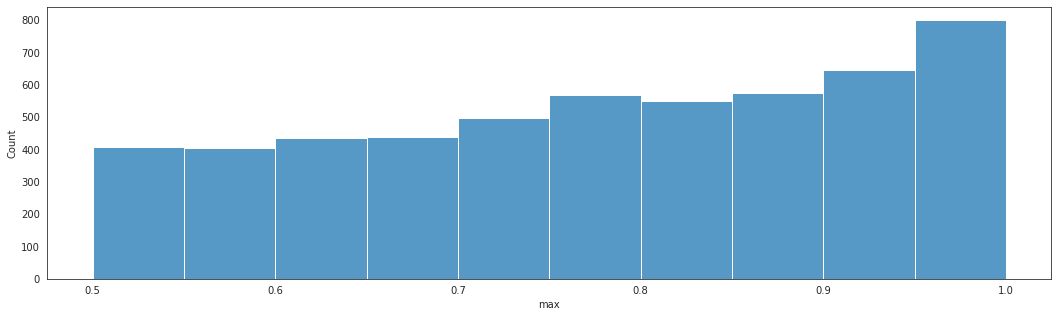

In [49]:
sns.histplot(data = df_pseudo, x = 'max', bins=10)
plt.show()

In [50]:
def check_score(model, scaler, X_train, y_train, X_test, y_test):
    
    """Function to confirm the confidence that best fit the data
    """
    with mlflow.start_run():
        mlflow.set_tag("developer", "daniel")
        mlflow.log_param("train-data1-path", os.path.join(config.DATAPATH, 'train.csv'))
        mlflow.log_param("train-data2-path", os.path.join(config.DATAPATH, 'HateSpeechData.csv'))
        
        print(f"Old Train Data shape: {X_train.shape[0]} \nOld Train label shape: {y_train.shape[0]}\n")
        nc=np.arange(.5,1,0.001)
        # print(len(nc))
        auc_scores=np.empty(len(nc))
        i=0
        for k in np.nditer(nc):
            conf_ind=df_pseudo["max"]>k
            X_new = np.append(X_train, unlabelled_cleaned[conf_ind,:],axis=0)
            y_new = np.append(y_train, df_pseudo.loc[conf_ind, ['lab']])
            test_model = make_pipeline(scaler, model)
            test_model.fit(X_new, y_new)
            pred = test_model.predict_proba(X_test)[:, 1]
            y_pred = test_model.predict(X_test)
            print(f"Iteration-> {i}")
            print(f"New Train Data shape: {X_new.shape[0]} \nNew Train label shape: {y_new.shape[0]}\n")
            # print(f"New Train instances remaining-> {len(X_new)}")
            misclass = np.mean(y_pred != y_test)*100
            print("'%' of Misclassified class:", misclass)
            auc_scores[i] = roc_auc_score(y_test, pred)
            print(f"{k}->{roc_auc_score(y_test, pred)}")
            print()
            with mlflow.start_run(nested=True):
                mlflow.set_tag("model", "lgb-tuning-sklearn-semi-supervised-learn")
                mlflow.log_params({"Iteration":i})
                mlflow.log_params({"New Train Data shape": X_new.shape[0]})
                mlflow.log_params({"New Train label shape": y_new.shape[0]})
                mlflow.log_params({"percent-misclassified":misclass})
                mlflow.log_params({"k":k})
                mlflow.log_metrics({"test-auc-score":roc_auc_score(y_test, pred)})
            i += 1
    return auc_scores, nc

def conf_and_roc_plot(auc, nc):
    compare=pd.Series(auc, index=nc)
    compare.plot()
    plt.title('Confidence vs ROC')
    plt.xlabel('Confidence')
    plt.ylabel('ROC Score')
    plt.show()

In [51]:
auc_scores, nc = check_score(lgb.LGBMClassifier(n_estimators=400, 
                                                reg_alpha=0.1,
                                                learning_rate=0.1,
                                                objective='binary',
                                                class_weight={0:1,1:1}),
                             StandardScaler(),
                             X_train, y_train, X_test, y_test)

Old Train Data shape: 45396 
Old Train label shape: 45396

Iteration-> 0
New Train Data shape: 50725 
New Train label shape: 50725

'%' of Misclassified class: 5.330866155608423
0.5->0.9824471869824729

Iteration-> 1
New Train Data shape: 50716 
New Train label shape: 50716

'%' of Misclassified class: 5.357300202661027
0.501->0.9822569900800494

Iteration-> 2
New Train Data shape: 50704 
New Train label shape: 50704

'%' of Misclassified class: 5.383734249713632
0.502->0.9826025098676477

Iteration-> 3
New Train Data shape: 50696 
New Train label shape: 50696

'%' of Misclassified class: 5.313243457573354
0.503->0.9823249580022971

Iteration-> 4
New Train Data shape: 50687 
New Train label shape: 50687

'%' of Misclassified class: 5.383734249713632
0.504->0.9823407686356391

Iteration-> 5
New Train Data shape: 50676 
New Train label shape: 50676

'%' of Misclassified class: 5.295620759538285
0.505->0.9823620652512767

Iteration-> 6
New Train Data shape: 50664 
New Train label shape: 5

Iteration-> 56
New Train Data shape: 50271 
New Train label shape: 50271

'%' of Misclassified class: 5.427790994801304
0.556->0.9823072054283196

Iteration-> 57
New Train Data shape: 50264 
New Train label shape: 50264

'%' of Misclassified class: 5.366111551678562
0.557->0.9823205400873511

Iteration-> 58
New Train Data shape: 50251 
New Train label shape: 50251

'%' of Misclassified class: 5.295620759538285
0.558->0.9826891851513524

Iteration-> 59
New Train Data shape: 50245 
New Train label shape: 50245

'%' of Misclassified class: 5.383734249713632
0.559->0.9824288680091431

Iteration-> 60
New Train Data shape: 50236 
New Train label shape: 50236

'%' of Misclassified class: 5.41897964578377
0.56->0.9822555821730886

Iteration-> 61
New Train Data shape: 50225 
New Train label shape: 50225

'%' of Misclassified class: 5.471847739888977
0.561->0.9823314473205881

Iteration-> 62
New Train Data shape: 50216 
New Train label shape: 50216

'%' of Misclassified class: 5.339677504625958


Iteration-> 108
New Train Data shape: 49848 
New Train label shape: 49848

'%' of Misclassified class: 5.392545598731166
0.6080000000000001->0.9823924566222247

Iteration-> 109
New Train Data shape: 49839 
New Train label shape: 49839

'%' of Misclassified class: 5.401356947748701
0.6090000000000001->0.9824724160278976

Iteration-> 110
New Train Data shape: 49833 
New Train label shape: 49833

'%' of Misclassified class: 5.383734249713632
0.6100000000000001->0.9826194694825323

Iteration-> 111
New Train Data shape: 49826 
New Train label shape: 49826

'%' of Misclassified class: 5.41897964578377
0.6110000000000001->0.9825549161392356

Iteration-> 112
New Train Data shape: 49818 
New Train label shape: 49818

'%' of Misclassified class: 5.383734249713632
0.6120000000000001->0.9826596029223359

Iteration-> 113
New Train Data shape: 49807 
New Train label shape: 49807

'%' of Misclassified class: 5.427790994801304
0.6130000000000001->0.982575257967394

Iteration-> 114
New Train Data shape

Iteration-> 159
New Train Data shape: 49410 
New Train label shape: 49410

'%' of Misclassified class: 5.4630363908714425
0.6590000000000001->0.9824971272224863

Iteration-> 160
New Train Data shape: 49404 
New Train label shape: 49404

'%' of Misclassified class: 5.339677504625958
0.6600000000000001->0.9824726911361544

Iteration-> 161
New Train Data shape: 49392 
New Train label shape: 49392

'%' of Misclassified class: 5.445413692836373
0.6610000000000001->0.9825452549845731

Iteration-> 162
New Train Data shape: 49376 
New Train label shape: 49376

'%' of Misclassified class: 5.480659088906512
0.6620000000000001->0.9822937736722563

Iteration-> 163
New Train Data shape: 49364 
New Train label shape: 49364

'%' of Misclassified class: 5.401356947748701
0.6630000000000001->0.9823468857486414

Iteration-> 164
New Train Data shape: 49359 
New Train label shape: 49359

'%' of Misclassified class: 5.392545598731166
0.6640000000000001->0.982392925924545

Iteration-> 165
New Train Data sha

Iteration-> 210
New Train Data shape: 48947 
New Train label shape: 48947

'%' of Misclassified class: 5.427790994801304
0.7100000000000002->0.9827961537146994

Iteration-> 211
New Train Data shape: 48938 
New Train label shape: 48938

'%' of Misclassified class: 5.383734249713632
0.7110000000000002->0.9824531099014115

Iteration-> 212
New Train Data shape: 48923 
New Train label shape: 48923

'%' of Misclassified class: 5.427790994801304
0.7120000000000002->0.9824865760116994

Iteration-> 213
New Train Data shape: 48913 
New Train label shape: 48913

'%' of Misclassified class: 5.322054806590889
0.7130000000000002->0.9824791157230907

Iteration-> 214
New Train Data shape: 48903 
New Train label shape: 48903

'%' of Misclassified class: 5.392545598731166
0.7140000000000002->0.9824428499817198

Iteration-> 215
New Train Data shape: 48896 
New Train label shape: 48896

'%' of Misclassified class: 5.366111551678562
0.7150000000000002->0.9827107406924079

Iteration-> 216
New Train Data sha

Iteration-> 261
New Train Data shape: 48413 
New Train label shape: 48413

'%' of Misclassified class: 5.357300202661027
0.7610000000000002->0.9825794978711151

Iteration-> 262
New Train Data shape: 48401 
New Train label shape: 48401

'%' of Misclassified class: 5.445413692836373
0.7620000000000002->0.9825560651207784

Iteration-> 263
New Train Data shape: 48394 
New Train label shape: 48394

'%' of Misclassified class: 5.322054806590889
0.7630000000000002->0.9825181325470286

Iteration-> 264
New Train Data shape: 48384 
New Train label shape: 48384

'%' of Misclassified class: 5.383734249713632
0.7640000000000002->0.9826167669484811

Iteration-> 265
New Train Data shape: 48371 
New Train label shape: 48371

'%' of Misclassified class: 5.436602343818839
0.7650000000000002->0.9825134395238259

Iteration-> 266
New Train Data shape: 48357 
New Train label shape: 48357

'%' of Misclassified class: 5.4630363908714425
0.7660000000000002->0.9822688359179268

Iteration-> 267
New Train Data sh

Iteration-> 312
New Train Data shape: 47840 
New Train label shape: 47840

'%' of Misclassified class: 5.374922900696097
0.8120000000000003->0.982669231711321

Iteration-> 313
New Train Data shape: 47829 
New Train label shape: 47829

'%' of Misclassified class: 5.374922900696097
0.8130000000000003->0.9827068891768139

Iteration-> 314
New Train Data shape: 47818 
New Train label shape: 47818

'%' of Misclassified class: 5.357300202661027
0.8140000000000003->0.9826704130585411

Iteration-> 315
New Train Data shape: 47807 
New Train label shape: 47807

'%' of Misclassified class: 5.436602343818839
0.8150000000000003->0.9824300655392018

Iteration-> 316
New Train Data shape: 47795 
New Train label shape: 47795

'%' of Misclassified class: 5.357300202661027
0.8160000000000003->0.9825446724023825

Iteration-> 317
New Train Data shape: 47788 
New Train label shape: 47788

'%' of Misclassified class: 5.3484888536434925
0.8170000000000003->0.9825957616239388

Iteration-> 318
New Train Data sha

Iteration-> 363
New Train Data shape: 47280 
New Train label shape: 47280

'%' of Misclassified class: 5.330866155608423
0.8630000000000003->0.9827147378535497

Iteration-> 364
New Train Data shape: 47269 
New Train label shape: 47269

'%' of Misclassified class: 5.322054806590889
0.8640000000000003->0.9827545638194193

Iteration-> 365
New Train Data shape: 47252 
New Train label shape: 47252

'%' of Misclassified class: 5.313243457573354
0.8650000000000003->0.9827359859206715

Iteration-> 366
New Train Data shape: 47243 
New Train label shape: 47243

'%' of Misclassified class: 5.374922900696097
0.8660000000000003->0.9828912440744918

Iteration-> 367
New Train Data shape: 47226 
New Train label shape: 47226

'%' of Misclassified class: 5.313243457573354
0.8670000000000003->0.9830340738082439

Iteration-> 368
New Train Data shape: 47219 
New Train label shape: 47219

'%' of Misclassified class: 5.286809410520751
0.8680000000000003->0.9827042190084401

Iteration-> 369
New Train Data sha

Iteration-> 414
New Train Data shape: 46657 
New Train label shape: 46657

'%' of Misclassified class: 5.242752665433078
0.9140000000000004->0.9828036787346626

Iteration-> 415
New Train Data shape: 46649 
New Train label shape: 46649

'%' of Misclassified class: 5.322054806590889
0.9150000000000004->0.9827383162494343

Iteration-> 416
New Train Data shape: 46633 
New Train label shape: 46633

'%' of Misclassified class: 5.401356947748701
0.9160000000000004->0.9827384780778207

Iteration-> 417
New Train Data shape: 46623 
New Train label shape: 46623

'%' of Misclassified class: 5.295620759538285
0.9170000000000004->0.982870044555886

Iteration-> 418
New Train Data shape: 46609 
New Train label shape: 46609

'%' of Misclassified class: 5.322054806590889
0.9180000000000004->0.9829744562307295

Iteration-> 419
New Train Data shape: 46599 
New Train label shape: 46599

'%' of Misclassified class: 5.366111551678562
0.9190000000000004->0.9828111713889486

Iteration-> 420
New Train Data shap

Iteration-> 465
New Train Data shape: 45950 
New Train label shape: 45950

'%' of Misclassified class: 5.277998061503216
0.9650000000000004->0.9829706856293285

Iteration-> 466
New Train Data shape: 45934 
New Train label shape: 45934

'%' of Misclassified class: 5.366111551678562
0.9660000000000004->0.9828862759430322

Iteration-> 467
New Train Data shape: 45921 
New Train label shape: 45921

'%' of Misclassified class: 5.392545598731166
0.9670000000000004->0.9830631381864242

Iteration-> 468
New Train Data shape: 45905 
New Train label shape: 45905

'%' of Misclassified class: 5.313243457573354
0.9680000000000004->0.983145249909635

Iteration-> 469
New Train Data shape: 45878 
New Train label shape: 45878

'%' of Misclassified class: 5.401356947748701
0.9690000000000004->0.9828928299926777

Iteration-> 470
New Train Data shape: 45861 
New Train label shape: 45861

'%' of Misclassified class: 5.366111551678562
0.9700000000000004->0.9830608078576615

Iteration-> 471
New Train Data shap

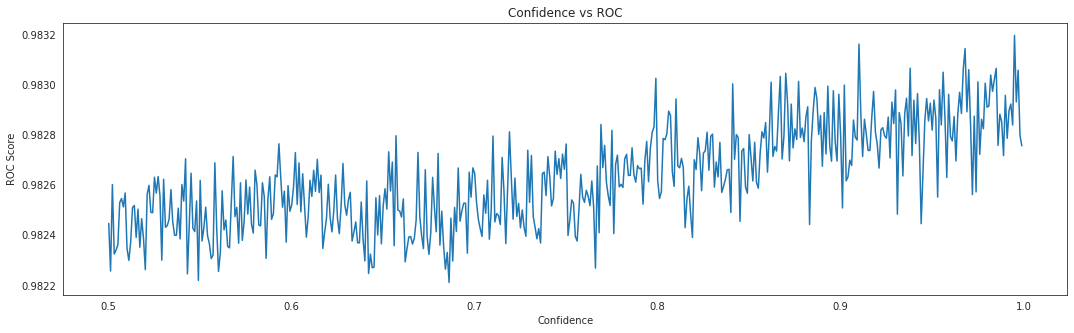

In [52]:
conf_and_roc_plot(auc_scores, nc)

We will consider probability/confidence at 0.85 begin to increase which is a good sign

**max -> ROC -> Misclassification**
1. 0.94 -> 0.9829 -> 5.3484
2. 0.996 -> 0.9827 -> 5.3132
3. 0.990 -> 0.9831 -> 5.3661
4. 0.976 -> 0.9830 -> 5.3308 -> Best
5. 0.985 -> 0.9827 -> 5.2956
6. 0.887 -> 0.9832 -> 5.3661

New Data ROC AUC LGBMClassifier Score semi-supervised: 0.9832
'%' of Misclassified class: 5.251564014450612


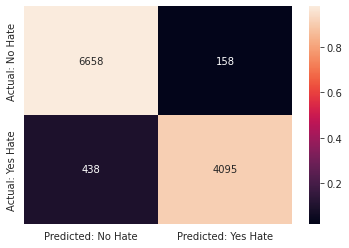

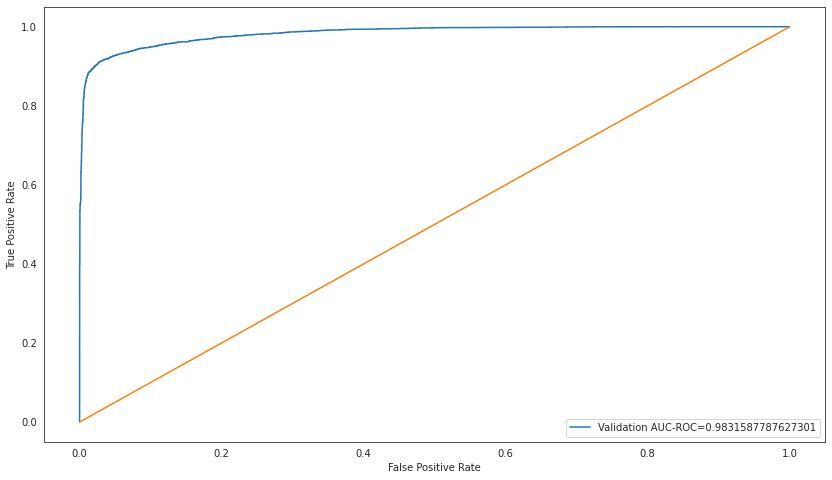

,Actual Label,Predicted_class
0,0,0
1,0,0
2,1,1
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,1,1


In [29]:
conf_ind=df_pseudo["max"]>0.979
X_train_new = np.append(X_train, unlabelled_cleaned[conf_ind,:],axis=0)
y_train_new = np.append(y_train, df_pseudo.loc[conf_ind, ['lab']])

y_pred, test_pred, train_pred = train(lgb.LGBMClassifier(n_estimators=400, reg_alpha=0.1, learning_rate=0.1,
                                                         objective='binary',
                                                         class_weight={0:1,1:1}),
                                      StandardScaler(),
                                      X_train_new, y_train_new, X_test)

auc = roc_auc_score(y_test, pred)
print(f"New Data ROC AUC LGBMClassifier Score semi-supervised: {auc:.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, pred)
plt.show()

out = pd.DataFrame(y_test[0:30])
out = out.rename(columns={0:'Actual Label'})
out['Predicted_class'] = y_pred[0:30]
out

In [80]:
print(len(X_train))
print(len(y_train))

45396
45396


In [81]:
print(len(X_train_new))
print(len(y_train_new))

45695
45695


## LightGBM & Parameter tuning

### Baseline LightGBM Model

[LightGBM] [Info] Number of positive: 18405, number of negative: 27290
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51638
[LightGBM] [Info] Number of data points in the train set: 45695, number of used features: 1018
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.402779 -> initscore=-0.393898
[LightGBM] [Info] Start training from score -0.393898
[1]	valid's auc: 0.950017
Training until validation scores don't improve for 1000 rounds
[2]	valid's auc: 0.951644
[3]	valid's auc: 0.954869
[4]	valid's auc: 0.954992
[5]	valid's auc: 0.956104
[6]	valid's auc: 0.958177
[7]	valid's auc: 0.958878
[8]	valid's auc: 0.959617
[9]	valid's auc: 0.96052
[10]	valid's auc: 0.960721
[11]	valid's auc: 0.962337
[12]	valid's auc: 0.962125
[13]	valid's auc: 0.962792
[14]	valid's auc: 0.96309
[15]	valid's auc: 0.963355
[16]	valid's auc: 0.965409
[17]	valid's auc

[283]	valid's auc: 0.982752
[284]	valid's auc: 0.982751
[285]	valid's auc: 0.982756
[286]	valid's auc: 0.982771
[287]	valid's auc: 0.982783
[288]	valid's auc: 0.982807
[289]	valid's auc: 0.982812
[290]	valid's auc: 0.982805
[291]	valid's auc: 0.98281
[292]	valid's auc: 0.982813
[293]	valid's auc: 0.982822
[294]	valid's auc: 0.982833
[295]	valid's auc: 0.982812
[296]	valid's auc: 0.982813
[297]	valid's auc: 0.982825
[298]	valid's auc: 0.982817
[299]	valid's auc: 0.982835
[300]	valid's auc: 0.982822
[301]	valid's auc: 0.982815
[302]	valid's auc: 0.982831
[303]	valid's auc: 0.982807
[304]	valid's auc: 0.982813
[305]	valid's auc: 0.982819
[306]	valid's auc: 0.982808
[307]	valid's auc: 0.982806
[308]	valid's auc: 0.982816
[309]	valid's auc: 0.982817
[310]	valid's auc: 0.982801
[311]	valid's auc: 0.982807
[312]	valid's auc: 0.982785
[313]	valid's auc: 0.982758
[314]	valid's auc: 0.982755
[315]	valid's auc: 0.982775
[316]	valid's auc: 0.982775
[317]	valid's auc: 0.982773
[318]	valid's auc: 0.

[579]	valid's auc: 0.982439
[580]	valid's auc: 0.982436
[581]	valid's auc: 0.982436
[582]	valid's auc: 0.982419
[583]	valid's auc: 0.982422
[584]	valid's auc: 0.982426
[585]	valid's auc: 0.982415
[586]	valid's auc: 0.982404
[587]	valid's auc: 0.98239
[588]	valid's auc: 0.982379
[589]	valid's auc: 0.982387
[590]	valid's auc: 0.982392
[591]	valid's auc: 0.982405
[592]	valid's auc: 0.982392
[593]	valid's auc: 0.982394
[594]	valid's auc: 0.982404
[595]	valid's auc: 0.982396
[596]	valid's auc: 0.982396
[597]	valid's auc: 0.982405
[598]	valid's auc: 0.982407
[599]	valid's auc: 0.982408
[600]	valid's auc: 0.982396
[601]	valid's auc: 0.982394
[602]	valid's auc: 0.982404
[603]	valid's auc: 0.982397
[604]	valid's auc: 0.982403
[605]	valid's auc: 0.982409
[606]	valid's auc: 0.982411
[607]	valid's auc: 0.982401
[608]	valid's auc: 0.982415
[609]	valid's auc: 0.982407
[610]	valid's auc: 0.982409
[611]	valid's auc: 0.982417
[612]	valid's auc: 0.982403
[613]	valid's auc: 0.982404
[614]	valid's auc: 0.

[874]	valid's auc: 0.981962
[875]	valid's auc: 0.981954
[876]	valid's auc: 0.981958
[877]	valid's auc: 0.981962
[878]	valid's auc: 0.98196
[879]	valid's auc: 0.981947
[880]	valid's auc: 0.981948
[881]	valid's auc: 0.981947
[882]	valid's auc: 0.98194
[883]	valid's auc: 0.981949
[884]	valid's auc: 0.981936
[885]	valid's auc: 0.98193
[886]	valid's auc: 0.981926
[887]	valid's auc: 0.981938
[888]	valid's auc: 0.981924
[889]	valid's auc: 0.98193
[890]	valid's auc: 0.98192
[891]	valid's auc: 0.981918
[892]	valid's auc: 0.981907
[893]	valid's auc: 0.981902
[894]	valid's auc: 0.981903
[895]	valid's auc: 0.981899
[896]	valid's auc: 0.981899
[897]	valid's auc: 0.981897
[898]	valid's auc: 0.981894
[899]	valid's auc: 0.981883
[900]	valid's auc: 0.981881
[901]	valid's auc: 0.98188
[902]	valid's auc: 0.98188
[903]	valid's auc: 0.981873
[904]	valid's auc: 0.98186
[905]	valid's auc: 0.981856
[906]	valid's auc: 0.981867
[907]	valid's auc: 0.981876
[908]	valid's auc: 0.981875
[909]	valid's auc: 0.981875


[1170]	valid's auc: 0.981595
[1171]	valid's auc: 0.981598
[1172]	valid's auc: 0.981607
[1173]	valid's auc: 0.981609
[1174]	valid's auc: 0.981593
[1175]	valid's auc: 0.98159
[1176]	valid's auc: 0.981579
[1177]	valid's auc: 0.981569
[1178]	valid's auc: 0.981574
[1179]	valid's auc: 0.981575
[1180]	valid's auc: 0.981579
[1181]	valid's auc: 0.981581
[1182]	valid's auc: 0.981572
[1183]	valid's auc: 0.981577
[1184]	valid's auc: 0.981576
[1185]	valid's auc: 0.98156
[1186]	valid's auc: 0.981558
[1187]	valid's auc: 0.981562
[1188]	valid's auc: 0.981556
[1189]	valid's auc: 0.981557
[1190]	valid's auc: 0.981553
[1191]	valid's auc: 0.98156
[1192]	valid's auc: 0.981565
[1193]	valid's auc: 0.981562
[1194]	valid's auc: 0.981578
[1195]	valid's auc: 0.981572
[1196]	valid's auc: 0.981573
[1197]	valid's auc: 0.981571
[1198]	valid's auc: 0.98157
[1199]	valid's auc: 0.981587
[1200]	valid's auc: 0.981585
Did not meet early stopping. Best iteration is:
[299]	valid's auc: 0.982835
Train AUC Score of the basemo

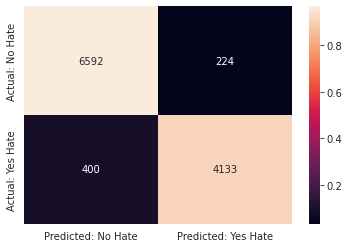

In [64]:
params = {
    'objective': 'binary',
    'is_unbalance': True,
    'metric':'auc'
}

lgb_train = lgb.Dataset(X_train_new, label=y_train_new)
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

with mlflow.start_run():
    mlflow.set_tag("developer", "daniel")
    mlflow.log_param("train-data1-path", os.path.join(config.DATAPATH, 'train.csv'))
    mlflow.log_param("train-data2-path", os.path.join(config.DATAPATH, 'HateSpeechData.csv'))
    mlflow.set_tag("model", "lgb-base")
    
    mlflow.log_params(params)
    basemodel = lgb.train(params, lgb_train,
                          valid_sets=[lgb_test],
                          num_boost_round=1200,
                          early_stopping_rounds=1000,
                          valid_names=['valid']
                         )
    
    train_prob = basemodel.predict(X_train, num_iteration=basemodel.best_iteration)
    test_prob = basemodel.predict(X_test, num_iteration=basemodel.best_iteration)
    
    y_pred = binary_predict(test_prob)
    
    train_auc = roc_auc_score(y_train, train_prob)
    test_auc = roc_auc_score(y_test, test_prob)
    misclass = np.mean(y_pred != y_test)*100

    mlflow.log_param("percent-misclassified",misclass)
    mlflow.log_metrics({"train-auc-score":train_auc})
    mlflow.log_metrics({"test-auc-score":test_auc})

print(f"Train AUC Score of the basemodel: {train_auc}")
print(f"Test AUC Score of the basemodel: {test_auc}")
print(f"AUC Score of the basemodel: {basemodel.best_score['valid']['auc']}")
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
plt.show()

***Best Model***

In [32]:
s3 = boto3.resource('s3',
     aws_access_key_id=AWS_ACCESS_KEY_ID,
     aws_secret_access_key= AWS_SECRET_ACCESS_KEY)

In [34]:
for bucket in s3.buckets.all():
    print(bucket.name)

mlflow-artifact-store-remote


In [31]:
fixed_params = {
        'objective': 'binary',
        'metric':'auc',
        'is_unbalance':True,
        'force_col_wise':True,
        'feature_pre_filter':False,
        'boosting':'dart',
        'num_boost_round':1200,
        'early_stopping_rounds':50,
        'num_threads':4
        }

params = {
    'feature_fraction':0.8,
    'lambda_l1':0.3970341857380282,
    'lambda_l2':0.20506586286248293,
    'learning_rate':0.02624259084185803,
    'max_depth':61,
    'min_data_in_leaf':31,
    'num_leaves':138,
    'seed':43
}

del lgb_train
del lgb_test

lgb_train = lgb.Dataset(X_train_new, label=y_train_new)
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

with mlflow.start_run(experiment_id=experiment_id, run_name='lgb-booster-tuning'):
    mlflow.set_tags(tags)
    mlflow.log_params({**params,**fixed_params})

    lgb_model = lgb.train({**params,**fixed_params}, lgb_train,
                          valid_sets=[lgb_train, lgb_test],
                          valid_names=['train','valid'],
                          num_boost_round=fixed_params["num_boost_round"],
                          early_stopping_rounds=fixed_params["early_stopping_rounds"])

    train_prob = lgb_model.predict(X_train, num_iteration=lgb_model.best_iteration)
    test_prob = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

    y_pred = binary_predict(test_prob)
        
    train_auc = roc_auc_score(y_train, train_prob)
    test_auc = roc_auc_score(y_test, test_prob)
    misclass = np.mean(y_pred != y_test)*100

    mlflow.log_param("percent-misclassified",misclass)
    mlflow.log_metrics({"train-auc-score":train_auc,
                        "test-auc-score":test_auc})
    
    mlflow.lightgbm.log_model(lgb_model, artifact_path="models")
    vec_path = './artifacts'
    with open(os.path.join(vec_path,'vectorizerV7.bin'), 'wb') as f:
        joblib.dump(tfVectorizer, f)
    mlflow.log_artifact(os.path.join(vec_path,'vectorizerV7.bin'), artifact_path="tfVectorizer")

mlflow.end_run()
print(f"Train AUC Score of the lgb python model: {train_auc}")
print(f"Test AUC Score of the lgb python model: {test_auc}")
print(f"AUC Score of the model: {lgb_model.best_score['valid']['auc']}")

[LightGBM] [Info] Number of positive: 18405, number of negative: 27290
[LightGBM] [Info] Total Bins 51638
[LightGBM] [Info] Number of data points in the train set: 45695, number of used features: 1018
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.402779 -> initscore=-0.393898
[LightGBM] [Info] Start training from score -0.393898
[1]	train's auc: 0.937465	valid's auc: 0.929695
[2]	train's auc: 0.970196	valid's auc: 0.964223
[3]	train's auc: 0.973731	valid's auc: 0.968201
[4]	train's auc: 0.973831	valid's auc: 0.968629
[5]	train's auc: 0.969866	valid's auc: 0.964034
[6]	train's auc: 0.970405	valid's auc: 0.965355
[7]	train's auc: 0.973572	valid's auc: 0.968802
[8]	train's auc: 0.973586	valid's auc: 0.968601
[9]	train's auc: 0.974239	valid's auc: 0.969428
[10]	train's auc: 0.974522	valid's auc: 0.969843
[11]	train's auc: 0.975311	valid's auc: 0.970543
[12]	train's auc: 0.975301	valid's auc: 0.970556
[13]	train's auc: 0.975329	valid's auc: 0.970692
[14]	train's auc: 0.97557	valid's auc

[161]	train's auc: 0.982699	valid's auc: 0.975997
[162]	train's auc: 0.982756	valid's auc: 0.97601
[163]	train's auc: 0.982911	valid's auc: 0.976188
[164]	train's auc: 0.982975	valid's auc: 0.976202
[165]	train's auc: 0.982971	valid's auc: 0.976191
[166]	train's auc: 0.98298	valid's auc: 0.976202
[167]	train's auc: 0.983113	valid's auc: 0.976315
[168]	train's auc: 0.983081	valid's auc: 0.976312
[169]	train's auc: 0.983075	valid's auc: 0.976305
[170]	train's auc: 0.983103	valid's auc: 0.97632
[171]	train's auc: 0.983143	valid's auc: 0.976323
[172]	train's auc: 0.98326	valid's auc: 0.976399
[173]	train's auc: 0.983234	valid's auc: 0.976376
[174]	train's auc: 0.983216	valid's auc: 0.976366
[175]	train's auc: 0.983199	valid's auc: 0.976351
[176]	train's auc: 0.98319	valid's auc: 0.976353
[177]	train's auc: 0.983239	valid's auc: 0.976399
[178]	train's auc: 0.983214	valid's auc: 0.976385
[179]	train's auc: 0.983208	valid's auc: 0.97638
[180]	train's auc: 0.983181	valid's auc: 0.976355
[181]	

[326]	train's auc: 0.986976	valid's auc: 0.978192
[327]	train's auc: 0.986967	valid's auc: 0.97819
[328]	train's auc: 0.98696	valid's auc: 0.978187
[329]	train's auc: 0.986951	valid's auc: 0.978186
[330]	train's auc: 0.986977	valid's auc: 0.978209
[331]	train's auc: 0.986972	valid's auc: 0.978208
[332]	train's auc: 0.986968	valid's auc: 0.97821
[333]	train's auc: 0.986995	valid's auc: 0.978196
[334]	train's auc: 0.98698	valid's auc: 0.978183
[335]	train's auc: 0.987037	valid's auc: 0.978231
[336]	train's auc: 0.987074	valid's auc: 0.978239
[337]	train's auc: 0.987068	valid's auc: 0.97824
[338]	train's auc: 0.987051	valid's auc: 0.978235
[339]	train's auc: 0.987087	valid's auc: 0.978212
[340]	train's auc: 0.987083	valid's auc: 0.978214
[341]	train's auc: 0.987099	valid's auc: 0.978229
[342]	train's auc: 0.987097	valid's auc: 0.978228
[343]	train's auc: 0.987131	valid's auc: 0.978228
[344]	train's auc: 0.987123	valid's auc: 0.978221
[345]	train's auc: 0.987119	valid's auc: 0.978222
[346]

[491]	train's auc: 0.989803	valid's auc: 0.979451
[492]	train's auc: 0.989862	valid's auc: 0.979537
[493]	train's auc: 0.989852	valid's auc: 0.979532
[494]	train's auc: 0.989866	valid's auc: 0.979522
[495]	train's auc: 0.989857	valid's auc: 0.97952
[496]	train's auc: 0.989903	valid's auc: 0.979573
[497]	train's auc: 0.98994	valid's auc: 0.979601
[498]	train's auc: 0.989935	valid's auc: 0.9796
[499]	train's auc: 0.989929	valid's auc: 0.979598
[500]	train's auc: 0.98997	valid's auc: 0.979596
[501]	train's auc: 0.989966	valid's auc: 0.979596
[502]	train's auc: 0.989959	valid's auc: 0.979593
[503]	train's auc: 0.989992	valid's auc: 0.979591
[504]	train's auc: 0.989988	valid's auc: 0.979592
[505]	train's auc: 0.990011	valid's auc: 0.979594
[506]	train's auc: 0.990003	valid's auc: 0.979589
[507]	train's auc: 0.990029	valid's auc: 0.979588
[508]	train's auc: 0.990021	valid's auc: 0.979585
[509]	train's auc: 0.990048	valid's auc: 0.979602
[510]	train's auc: 0.990093	valid's auc: 0.979648
[511]

[657]	train's auc: 0.992511	valid's auc: 0.981107
[658]	train's auc: 0.992509	valid's auc: 0.981109
[659]	train's auc: 0.992508	valid's auc: 0.981111
[660]	train's auc: 0.992505	valid's auc: 0.981112
[661]	train's auc: 0.992504	valid's auc: 0.981112
[662]	train's auc: 0.992503	valid's auc: 0.981112
[663]	train's auc: 0.992527	valid's auc: 0.98114
[664]	train's auc: 0.992544	valid's auc: 0.981141
[665]	train's auc: 0.992547	valid's auc: 0.981142
[666]	train's auc: 0.992559	valid's auc: 0.981135
[667]	train's auc: 0.992578	valid's auc: 0.981114
[668]	train's auc: 0.992607	valid's auc: 0.981109
[669]	train's auc: 0.992644	valid's auc: 0.981095
[670]	train's auc: 0.992688	valid's auc: 0.981124
[671]	train's auc: 0.992685	valid's auc: 0.981124
[672]	train's auc: 0.992683	valid's auc: 0.981125
[673]	train's auc: 0.992683	valid's auc: 0.981125
[674]	train's auc: 0.992682	valid's auc: 0.981126
[675]	train's auc: 0.992679	valid's auc: 0.981125
[676]	train's auc: 0.992676	valid's auc: 0.981124
[

[822]	train's auc: 0.994366	valid's auc: 0.982003
[823]	train's auc: 0.994365	valid's auc: 0.982005
[824]	train's auc: 0.994364	valid's auc: 0.982005
[825]	train's auc: 0.994366	valid's auc: 0.982006
[826]	train's auc: 0.994366	valid's auc: 0.982006
[827]	train's auc: 0.994367	valid's auc: 0.982007
[828]	train's auc: 0.994368	valid's auc: 0.982006
[829]	train's auc: 0.994368	valid's auc: 0.982008
[830]	train's auc: 0.994368	valid's auc: 0.982006
[831]	train's auc: 0.994363	valid's auc: 0.982005
[832]	train's auc: 0.994364	valid's auc: 0.982006
[833]	train's auc: 0.994381	valid's auc: 0.981995
[834]	train's auc: 0.994381	valid's auc: 0.981996
[835]	train's auc: 0.994381	valid's auc: 0.981996
[836]	train's auc: 0.994376	valid's auc: 0.981993
[837]	train's auc: 0.994384	valid's auc: 0.982008
[838]	train's auc: 0.994385	valid's auc: 0.982009
[839]	train's auc: 0.994412	valid's auc: 0.98201
[840]	train's auc: 0.994432	valid's auc: 0.981995
[841]	train's auc: 0.994445	valid's auc: 0.98199
[8

[989]	train's auc: 0.99584	valid's auc: 0.982608
[990]	train's auc: 0.995842	valid's auc: 0.982608
[991]	train's auc: 0.995849	valid's auc: 0.982608
[992]	train's auc: 0.99585	valid's auc: 0.98261
[993]	train's auc: 0.995852	valid's auc: 0.98261
[994]	train's auc: 0.995863	valid's auc: 0.982589
[995]	train's auc: 0.995872	valid's auc: 0.982587
[996]	train's auc: 0.995871	valid's auc: 0.982587
[997]	train's auc: 0.995896	valid's auc: 0.982604
[998]	train's auc: 0.995912	valid's auc: 0.982627
[999]	train's auc: 0.995912	valid's auc: 0.982628
[1000]	train's auc: 0.995911	valid's auc: 0.982628
[1001]	train's auc: 0.995913	valid's auc: 0.982628
[1002]	train's auc: 0.995929	valid's auc: 0.982638
[1003]	train's auc: 0.995938	valid's auc: 0.98265
[1004]	train's auc: 0.995949	valid's auc: 0.982672
[1005]	train's auc: 0.995967	valid's auc: 0.982681
[1006]	train's auc: 0.995986	valid's auc: 0.982663
[1007]	train's auc: 0.995985	valid's auc: 0.982664
[1008]	train's auc: 0.995996	valid's auc: 0.982

[1151]	train's auc: 0.996955	valid's auc: 0.982999
[1152]	train's auc: 0.996956	valid's auc: 0.983
[1153]	train's auc: 0.996972	valid's auc: 0.982991
[1154]	train's auc: 0.996973	valid's auc: 0.982991
[1155]	train's auc: 0.996992	valid's auc: 0.983006
[1156]	train's auc: 0.997007	valid's auc: 0.983002
[1157]	train's auc: 0.997024	valid's auc: 0.983012
[1158]	train's auc: 0.997024	valid's auc: 0.983012
[1159]	train's auc: 0.997029	valid's auc: 0.983014
[1160]	train's auc: 0.997035	valid's auc: 0.983013
[1161]	train's auc: 0.997037	valid's auc: 0.983015
[1162]	train's auc: 0.997038	valid's auc: 0.983015
[1163]	train's auc: 0.997046	valid's auc: 0.983018
[1164]	train's auc: 0.997053	valid's auc: 0.983022
[1165]	train's auc: 0.997053	valid's auc: 0.983023
[1166]	train's auc: 0.997052	valid's auc: 0.983023
[1167]	train's auc: 0.997054	valid's auc: 0.983024
[1168]	train's auc: 0.997064	valid's auc: 0.983015
[1169]	train's auc: 0.997065	valid's auc: 0.983015
[1170]	train's auc: 0.997068	valid

NoCredentialsError: Unable to locate credentials

In [ ]:
train_auc = roc_auc_score(y_train, train_prob)
test_auc = roc_auc_score(y_test, test_prob)
misclass = np.mean(y_pred != y_test)*100
print(f"Train AUC Score of the lgb python model: {train_auc}")
print(f"Test AUC Score of the lgb python model: {test_auc}")
print("'%' of Misclassified class:",misclass)

cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, test_prob)
plt.show()

out = pd.DataFrame(y_test[0:30])
out = out.rename(columns={0:'Actual Label'})
out['Predicted_class'] = y_pred[0:30]
out['Probability'] = test_prob[0:30]
out

# Apply SMOTE to new data

In [94]:
print(X_train_new.shape)
print(y_train_new.shape)
print(Counter(y_train_new))

(45695, 1018)
(45695,)
Counter({0: 27290, 1: 18405})


In [ ]:
X_train_new_ada, y_train_new_ada = ADASYN(random_state = 43).fit_resample(X_train_new, y_train_new)
print(X_train_new_ada.shape)
print(y_train_new_ada.shape)
print(Counter(y_train_new_ada))

In [ ]:
del lgb_train
del lgb_test

lgb_train_new_ada = lgb.Dataset(X_train_new_ada, label=y_train_new_ada)
lgb_test_new_ada = lgb.Dataset(X_test, label=y_test, reference=lgb_train_new_ada)

fixed_params = {
        'objective': 'binary',
        'metric':'auc',
        'is_unbalance':True,
        'force_col_wise':True,
        'feature_pre_filter':False,
        'boosting':'dart',
        'num_boost_round':1200,
        'early_stopping_rounds':50,
        'num_threads':4
        }

params = {
    'feature_fraction':0.8,
    'lambda_l1':0.3970341857380282,
    'lambda_l2':0.20506586286248293,
    'learning_rate':0.02624259084185803,
    'max_depth':61,
    'min_data_in_leaf':31,
    'num_leaves':138,
    'seed':43
}

with mlflow.start_run(experiment_id=experiment_id, run_name='lgb-booster-ada'):
    mlflow.set_tags(tags)
    mlflow.log_params({**params,**fixed_params})
        
    lgb_model_ada = lgb.train({**params,**fixed_params}, lgb_train_new_ada,
                             valid_sets=[lgb_train_new_ada, lgb_test_new_ada],
                             valid_names=['train','valid'],
                             num_boost_round=fixed_params["num_boost_round"],
                             early_stopping_rounds=fixed_params["early_stopping_rounds"])

    train_prob = lgb_model_ada.predict(X_train, num_iteration=lgb_model_ada.best_iteration)
    test_prob = lgb_model_ada.predict(X_test, num_iteration=lgb_model_ada.best_iteration)

    y_pred = binary_predict(test_prob)

    train_auc = roc_auc_score(y_train, train_prob)
    test_auc = roc_auc_score(y_test, test_prob)
    misclass = np.mean(y_pred != y_test)*100
    
    mlflow.log_params({"percent-misclassified":misclass,
                     "SMOTE":'ada'})
    mlflow.log_metrics({"train-auc-score":train_auc,
                        "test-auc-score":test_auc})
    
    vec_path = './artifacts'
    with open(os.path.join(vec_path,'vectorizerV7.bin'), 'wb') as f:
        joblib.dump(tfVectorizer, f)
    mlflow.lightgbm.log_model(lgb_model_ada, artifact_path="models")
    mlflow.log_artifact(os.path.join(vec_path,'vectorizerV7.bin'), artifact_path="tfVectorizer")
    
mlflow.end_run()
print(f"Train ROC AUC LGBM Model Score with ADASYN: {train_auc:.4f}")
print(f"Test ROC AUC LGBM Model Score with ADASYN: {test_auc:.4f}")
print("'%' of Misclassified class:", misclass)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, test_prob)
plt.show()

out = pd.DataFrame(y_test[0:30])
out = out.rename(columns={0:'Actual Label'})
out['Predicted_class'] = y_pred[0:30]
out['Probability'] = test_prob[0:30]
out

(54580, 1018)
(54580,)
Counter({0: 27290, 1: 27290})
[LightGBM] [Info] Number of positive: 27290, number of negative: 27290
[LightGBM] [Info] Total Bins 71029
[LightGBM] [Info] Number of data points in the train set: 54580, number of used features: 1018
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[1]	train's auc: 0.947638	valid's auc: 0.93087
[2]	train's auc: 0.976329	valid's auc: 0.964783
[3]	train's auc: 0.979841	valid's auc: 0.967873
[4]	train's auc: 0.980009	valid's auc: 0.968957
[5]	train's auc: 0.977752	valid's auc: 0.964622
[6]	train's auc: 0.978099	valid's auc: 0.966448
[7]	train's auc: 0.980445	valid's auc: 0.968988
[8]	train's auc: 0.980517	valid's auc: 0.969027
[9]	train's auc: 0.980966	valid's auc: 0.969402
[10]	train's auc: 0.98108	valid's auc: 0.969635
[11]	train's auc: 0.981448	valid's auc: 0.969952
[12]	train's auc: 0.98149	valid's auc: 0.970324
[13]	train's auc: 0.981429	valid's auc: 0.970505
[14]	train's auc: 0.981526	valid's auc: 0.

[165]	train's auc: 0.987126	valid's auc: 0.975861
[166]	train's auc: 0.98713	valid's auc: 0.975867
[167]	train's auc: 0.98727	valid's auc: 0.976063
[168]	train's auc: 0.987241	valid's auc: 0.976053
[169]	train's auc: 0.987235	valid's auc: 0.976044
[170]	train's auc: 0.987265	valid's auc: 0.97609
[171]	train's auc: 0.987284	valid's auc: 0.97609
[172]	train's auc: 0.987375	valid's auc: 0.976155
[173]	train's auc: 0.987359	valid's auc: 0.976136
[174]	train's auc: 0.987346	valid's auc: 0.976121
[175]	train's auc: 0.987337	valid's auc: 0.976109
[176]	train's auc: 0.987331	valid's auc: 0.976106
[177]	train's auc: 0.987376	valid's auc: 0.976143
[178]	train's auc: 0.987359	valid's auc: 0.976125
[179]	train's auc: 0.987355	valid's auc: 0.976123
[180]	train's auc: 0.987331	valid's auc: 0.976099
[181]	train's auc: 0.987323	valid's auc: 0.976085
[182]	train's auc: 0.987321	valid's auc: 0.97608
[183]	train's auc: 0.98732	valid's auc: 0.97607
[184]	train's auc: 0.987326	valid's auc: 0.976074
[185]	t

[331]	train's auc: 0.989948	valid's auc: 0.977709
[332]	train's auc: 0.989946	valid's auc: 0.977711
[333]	train's auc: 0.989977	valid's auc: 0.977686
[334]	train's auc: 0.989968	valid's auc: 0.977679
[335]	train's auc: 0.990003	valid's auc: 0.977706
[336]	train's auc: 0.990044	valid's auc: 0.977724
[337]	train's auc: 0.99004	valid's auc: 0.977724
[338]	train's auc: 0.990027	valid's auc: 0.977717
[339]	train's auc: 0.990058	valid's auc: 0.97774
[340]	train's auc: 0.990055	valid's auc: 0.977741
[341]	train's auc: 0.990068	valid's auc: 0.97774
[342]	train's auc: 0.990066	valid's auc: 0.977739
[343]	train's auc: 0.990103	valid's auc: 0.977744
[344]	train's auc: 0.990097	valid's auc: 0.97774
[345]	train's auc: 0.990096	valid's auc: 0.97774
[346]	train's auc: 0.990087	valid's auc: 0.977733
[347]	train's auc: 0.990133	valid's auc: 0.977764
[348]	train's auc: 0.990148	valid's auc: 0.977771
[349]	train's auc: 0.99017	valid's auc: 0.977788
[350]	train's auc: 0.990165	valid's auc: 0.977788
[351]	

[498]	train's auc: 0.992023	valid's auc: 0.978949
[499]	train's auc: 0.992019	valid's auc: 0.978945
[500]	train's auc: 0.992046	valid's auc: 0.978945
[501]	train's auc: 0.992044	valid's auc: 0.978945
[502]	train's auc: 0.992041	valid's auc: 0.978944
[503]	train's auc: 0.992065	valid's auc: 0.978947
[504]	train's auc: 0.992062	valid's auc: 0.978946
[505]	train's auc: 0.992084	valid's auc: 0.978959
[506]	train's auc: 0.992079	valid's auc: 0.978957
[507]	train's auc: 0.992087	valid's auc: 0.97894
[508]	train's auc: 0.992083	valid's auc: 0.978936
[509]	train's auc: 0.992107	valid's auc: 0.978957
[510]	train's auc: 0.992139	valid's auc: 0.978994
[511]	train's auc: 0.992134	valid's auc: 0.978993
[512]	train's auc: 0.992131	valid's auc: 0.978993
[513]	train's auc: 0.992128	valid's auc: 0.978991
[514]	train's auc: 0.992144	valid's auc: 0.97901
[515]	train's auc: 0.992168	valid's auc: 0.979013
[516]	train's auc: 0.992166	valid's auc: 0.979012
[517]	train's auc: 0.992199	valid's auc: 0.979049
[5

[665]	train's auc: 0.994139	valid's auc: 0.980475
[666]	train's auc: 0.994157	valid's auc: 0.980476
[667]	train's auc: 0.994173	valid's auc: 0.980481
[668]	train's auc: 0.994194	valid's auc: 0.980487
[669]	train's auc: 0.994221	valid's auc: 0.980478
[670]	train's auc: 0.994243	valid's auc: 0.980481
[671]	train's auc: 0.994242	valid's auc: 0.980482
[672]	train's auc: 0.99424	valid's auc: 0.980482
[673]	train's auc: 0.994241	valid's auc: 0.98048
[674]	train's auc: 0.99424	valid's auc: 0.98048
[675]	train's auc: 0.994239	valid's auc: 0.98048
[676]	train's auc: 0.994236	valid's auc: 0.980481
[677]	train's auc: 0.994233	valid's auc: 0.980479
[678]	train's auc: 0.994268	valid's auc: 0.980517
[679]	train's auc: 0.994283	valid's auc: 0.980511
[680]	train's auc: 0.994308	valid's auc: 0.980551
[681]	train's auc: 0.994341	valid's auc: 0.980592
[682]	train's auc: 0.994357	valid's auc: 0.980585
[683]	train's auc: 0.994358	valid's auc: 0.980584
[684]	train's auc: 0.994356	valid's auc: 0.980586
[685]

[830]	train's auc: 0.995599	valid's auc: 0.981533
[831]	train's auc: 0.995596	valid's auc: 0.981535
[832]	train's auc: 0.995596	valid's auc: 0.981535
[833]	train's auc: 0.995603	valid's auc: 0.981532
[834]	train's auc: 0.995603	valid's auc: 0.981533
[835]	train's auc: 0.995603	valid's auc: 0.981532
[836]	train's auc: 0.995599	valid's auc: 0.981529
[837]	train's auc: 0.995606	valid's auc: 0.981534
[838]	train's auc: 0.995607	valid's auc: 0.981535
[839]	train's auc: 0.995621	valid's auc: 0.981533
[840]	train's auc: 0.995631	valid's auc: 0.981546
[841]	train's auc: 0.995639	valid's auc: 0.981533
[842]	train's auc: 0.995655	valid's auc: 0.981534
[843]	train's auc: 0.995655	valid's auc: 0.981533
[844]	train's auc: 0.995655	valid's auc: 0.981534
[845]	train's auc: 0.995655	valid's auc: 0.981535
[846]	train's auc: 0.995656	valid's auc: 0.981537
[847]	train's auc: 0.995666	valid's auc: 0.981529
[848]	train's auc: 0.995668	valid's auc: 0.981531
[849]	train's auc: 0.995683	valid's auc: 0.981518


[996]	train's auc: 0.996726	valid's auc: 0.98238
[997]	train's auc: 0.99674	valid's auc: 0.982386
[998]	train's auc: 0.996756	valid's auc: 0.982403
[999]	train's auc: 0.996756	valid's auc: 0.982403
[1000]	train's auc: 0.996756	valid's auc: 0.982403
[1001]	train's auc: 0.996758	valid's auc: 0.982404
[1002]	train's auc: 0.996767	valid's auc: 0.982401
[1003]	train's auc: 0.996779	valid's auc: 0.982412
[1004]	train's auc: 0.996785	valid's auc: 0.982408
[1005]	train's auc: 0.9968	valid's auc: 0.982425
[1006]	train's auc: 0.996812	valid's auc: 0.982434
[1007]	train's auc: 0.996812	valid's auc: 0.982433
[1008]	train's auc: 0.996825	valid's auc: 0.98247
[1009]	train's auc: 0.996839	valid's auc: 0.982489
[1010]	train's auc: 0.996838	valid's auc: 0.982487
[1011]	train's auc: 0.996839	valid's auc: 0.982488
[1012]	train's auc: 0.996851	valid's auc: 0.982501
[1013]	train's auc: 0.996852	valid's auc: 0.982502
[1014]	train's auc: 0.996852	valid's auc: 0.982504
[1015]	train's auc: 0.996861	valid's auc

[1158]	train's auc: 0.997642	valid's auc: 0.982919
[1159]	train's auc: 0.997644	valid's auc: 0.982922
[1160]	train's auc: 0.997653	valid's auc: 0.982939
[1161]	train's auc: 0.997655	valid's auc: 0.982938
[1162]	train's auc: 0.997655	valid's auc: 0.98294
[1163]	train's auc: 0.997664	valid's auc: 0.982949
[1164]	train's auc: 0.997669	valid's auc: 0.982957
[1165]	train's auc: 0.997669	valid's auc: 0.982958
[1166]	train's auc: 0.997669	valid's auc: 0.982959
[1167]	train's auc: 0.997671	valid's auc: 0.98296
[1168]	train's auc: 0.997672	valid's auc: 0.982961
[1169]	train's auc: 0.997674	valid's auc: 0.982961
[1170]	train's auc: 0.997676	valid's auc: 0.982963
[1171]	train's auc: 0.997678	valid's auc: 0.982964
[1172]	train's auc: 0.997679	valid's auc: 0.982965
[1173]	train's auc: 0.99768	valid's auc: 0.982965
[1174]	train's auc: 0.997683	valid's auc: 0.982964
[1175]	train's auc: 0.997693	valid's auc: 0.982963
[1176]	train's auc: 0.997697	valid's auc: 0.982971
[1177]	train's auc: 0.99771	valid'

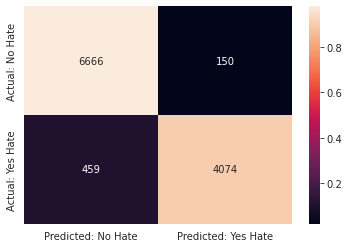

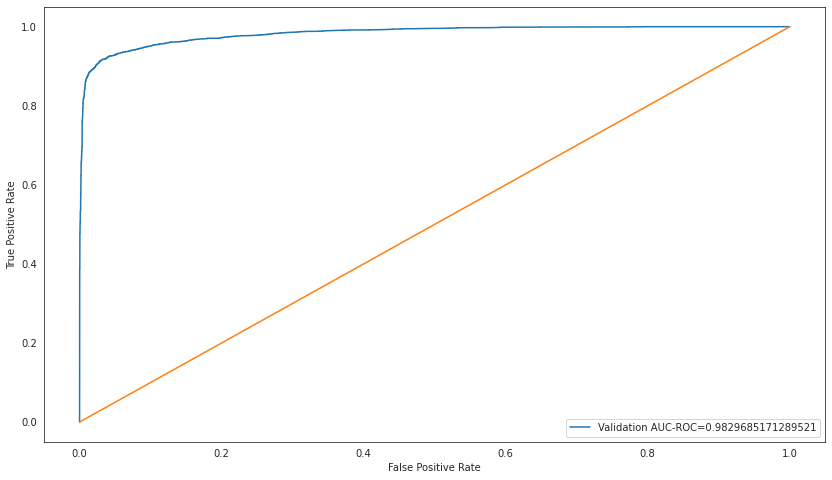

,Actual Label,Predicted_class,Probability
0,0,0,0.062464
1,0,0,0.049565
2,1,1,0.997001
3,0,0,0.004300
4,0,0,0.050752
5,0,0,0.484044
6,0,0,0.347793
7,0,0,0.005414
8,0,0,0.006234
9,1,1,0.997476


In [103]:
X_train_new_bls, y_train_new_bls = BorderlineSMOTE(random_state = 43).fit_resample(X_train_new, y_train_new)
print(X_train_new_bls.shape)
print(y_train_new_bls.shape)
print(Counter(y_train_new_bls))

lgb_train_new_bls = lgb.Dataset(X_train_new_bls, label=y_train_new_bls)
lgb_test_new_bls = lgb.Dataset(X_test, label=y_test, reference=lgb_train_new_bls)

with mlflow.start_run(experiment_id=experiment_id, run_name='lgb-booster-bls'):
    mlflow.set_tags(tags)
    mlflow.log_params({**params,**fixed_params})
    
    lgb_model_bls = lgb.train({**params,**fixed_params}, lgb_train_new_bls,
                              valid_sets=[lgb_train_new_bls, lgb_test_new_bls],
                              valid_names=['train','valid'],
                              num_boost_round=fixed_params["num_boost_round"],
                              early_stopping_rounds=fixed_params["early_stopping_rounds"])

    train_prob = lgb_model_bls.predict(X_train, num_iteration=lgb_model_bls.best_iteration)
    test_prob = lgb_model_bls.predict(X_test, num_iteration=lgb_model_bls.best_iteration)

    y_pred = binary_predict(test_prob)

    train_auc = roc_auc_score(y_train, train_prob)
    test_auc = roc_auc_score(y_test, test_prob)
    misclass = np.mean(y_pred != y_test)*100
    
    mlflow.log_params({"percent-misclassified":misclass,
                       "SMOTE":'bls'})
    mlflow.log_metrics({"train-auc-score":train_auc,
                        "test-auc-score":test_auc})
    
    vec_path = './artifacts'
    with open(os.path.join(vec_path,'vectorizerV7.bin'), 'wb') as f:
        joblib.dump(tfVectorizer, f)
    mlflow.lightgbm.log_model(lgb_model_ada, artifact_path="models")
    mlflow.log_artifact(os.path.join(vec_path,'vectorizerV7.bin'), artifact_path="tfVectorizer")

mlflow.end_run()
print(f"Train ROC AUC LGBM Model Score before Semi-Supervised Learning: {train_auc:.4f}")
print(f"Test ROC AUC LGBM Model Score before Semi-Supervised Learning: {test_auc:.4f}")
print("'%' of Misclassified class:", misclass)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, test_prob)
plt.show()

out = pd.DataFrame(y_test[0:30])
out = out.rename(columns={0:'Actual Label'})
out['Predicted_class'] = y_pred[0:30]
out['Probability'] = test_prob[0:30]
out

In [104]:
smote_pipe = Pipeline([('over', SMOTE(random_state = 11, sampling_strategy=0.8)),
                     ('under', RandomUnderSampler(sampling_strategy=0.9))]
                   )

X_train_new_sm, y_train_new_sm = smote_pipe.fit_resample(X_train_new, y_train_new)
print(X_train_new_sm.shape)
print(y_train_new_sm.shape)
print(Counter(y_train_new_sm))

(46089, 1018)
(46089,)
Counter({0: 24257, 1: 21832})


[LightGBM] [Info] Number of positive: 21832, number of negative: 24257
[LightGBM] [Info] Total Bins 58569
[LightGBM] [Info] Number of data points in the train set: 46089, number of used features: 1018
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473692 -> initscore=-0.105328
[LightGBM] [Info] Start training from score -0.105328
[1]	train's auc: 0.94368	valid's auc: 0.929153
[2]	train's auc: 0.973504	valid's auc: 0.963294
[3]	train's auc: 0.976987	valid's auc: 0.967841
[4]	train's auc: 0.976999	valid's auc: 0.968226
[5]	train's auc: 0.973491	valid's auc: 0.96316
[6]	train's auc: 0.974058	valid's auc: 0.965035
[7]	train's auc: 0.976448	valid's auc: 0.967933
[8]	train's auc: 0.976395	valid's auc: 0.967862
[9]	train's auc: 0.977134	valid's auc: 0.968792
[10]	train's auc: 0.977368	valid's auc: 0.96904
[11]	train's auc: 0.978101	valid's auc: 0.969941
[12]	train's auc: 0.978188	valid's auc: 0.970017
[13]	train's auc: 0.978275	valid's auc: 0.970276
[14]	train's auc: 0.978449	valid's auc: 

[165]	train's auc: 0.984602	valid's auc: 0.97589
[166]	train's auc: 0.984608	valid's auc: 0.975891
[167]	train's auc: 0.984781	valid's auc: 0.976083
[168]	train's auc: 0.984741	valid's auc: 0.976033
[169]	train's auc: 0.984736	valid's auc: 0.976029
[170]	train's auc: 0.984775	valid's auc: 0.97606
[171]	train's auc: 0.984811	valid's auc: 0.976085
[172]	train's auc: 0.984943	valid's auc: 0.976133
[173]	train's auc: 0.984916	valid's auc: 0.976112
[174]	train's auc: 0.984899	valid's auc: 0.976105
[175]	train's auc: 0.984883	valid's auc: 0.976087
[176]	train's auc: 0.984875	valid's auc: 0.976075
[177]	train's auc: 0.984934	valid's auc: 0.976133
[178]	train's auc: 0.98491	valid's auc: 0.976115
[179]	train's auc: 0.984904	valid's auc: 0.976111
[180]	train's auc: 0.984875	valid's auc: 0.976079
[181]	train's auc: 0.984868	valid's auc: 0.976068
[182]	train's auc: 0.984871	valid's auc: 0.976068
[183]	train's auc: 0.98487	valid's auc: 0.976061
[184]	train's auc: 0.984876	valid's auc: 0.976063
[185

[331]	train's auc: 0.988183	valid's auc: 0.977812
[332]	train's auc: 0.98818	valid's auc: 0.977813
[333]	train's auc: 0.988209	valid's auc: 0.977795
[334]	train's auc: 0.988194	valid's auc: 0.977788
[335]	train's auc: 0.988239	valid's auc: 0.977785
[336]	train's auc: 0.988286	valid's auc: 0.977801
[337]	train's auc: 0.98828	valid's auc: 0.9778
[338]	train's auc: 0.988266	valid's auc: 0.977792
[339]	train's auc: 0.988304	valid's auc: 0.977813
[340]	train's auc: 0.9883	valid's auc: 0.977813
[341]	train's auc: 0.988335	valid's auc: 0.977808
[342]	train's auc: 0.988333	valid's auc: 0.977808
[343]	train's auc: 0.988363	valid's auc: 0.977811
[344]	train's auc: 0.988356	valid's auc: 0.977803
[345]	train's auc: 0.988355	valid's auc: 0.977799
[346]	train's auc: 0.988343	valid's auc: 0.977791
[347]	train's auc: 0.988383	valid's auc: 0.977781
[348]	train's auc: 0.988409	valid's auc: 0.977798
[349]	train's auc: 0.988438	valid's auc: 0.977831
[350]	train's auc: 0.98843	valid's auc: 0.97783
[351]	tr

[498]	train's auc: 0.990716	valid's auc: 0.9792
[499]	train's auc: 0.990711	valid's auc: 0.979196
[500]	train's auc: 0.990735	valid's auc: 0.979191
[501]	train's auc: 0.990732	valid's auc: 0.979188
[502]	train's auc: 0.990726	valid's auc: 0.979186
[503]	train's auc: 0.990751	valid's auc: 0.979192
[504]	train's auc: 0.990748	valid's auc: 0.979191
[505]	train's auc: 0.990766	valid's auc: 0.979184
[506]	train's auc: 0.990759	valid's auc: 0.97918
[507]	train's auc: 0.990793	valid's auc: 0.979192
[508]	train's auc: 0.990786	valid's auc: 0.979189
[509]	train's auc: 0.990822	valid's auc: 0.979215
[510]	train's auc: 0.990857	valid's auc: 0.979243
[511]	train's auc: 0.990851	valid's auc: 0.979239
[512]	train's auc: 0.990846	valid's auc: 0.979236
[513]	train's auc: 0.990843	valid's auc: 0.979237
[514]	train's auc: 0.990876	valid's auc: 0.979259
[515]	train's auc: 0.9909	valid's auc: 0.979287
[516]	train's auc: 0.990897	valid's auc: 0.979284
[517]	train's auc: 0.990941	valid's auc: 0.979289
[518]

[665]	train's auc: 0.993305	valid's auc: 0.980724
[666]	train's auc: 0.993336	valid's auc: 0.980723
[667]	train's auc: 0.993367	valid's auc: 0.98072
[668]	train's auc: 0.993402	valid's auc: 0.980737
[669]	train's auc: 0.99343	valid's auc: 0.98073
[670]	train's auc: 0.993454	valid's auc: 0.98076
[671]	train's auc: 0.993452	valid's auc: 0.98076
[672]	train's auc: 0.99345	valid's auc: 0.980759
[673]	train's auc: 0.99345	valid's auc: 0.980759
[674]	train's auc: 0.993449	valid's auc: 0.98076
[675]	train's auc: 0.993447	valid's auc: 0.980758
[676]	train's auc: 0.993444	valid's auc: 0.980757
[677]	train's auc: 0.993439	valid's auc: 0.980754
[678]	train's auc: 0.993468	valid's auc: 0.980794
[679]	train's auc: 0.993509	valid's auc: 0.98082
[680]	train's auc: 0.993546	valid's auc: 0.980827
[681]	train's auc: 0.993576	valid's auc: 0.980859
[682]	train's auc: 0.993592	valid's auc: 0.980861
[683]	train's auc: 0.993592	valid's auc: 0.980861
[684]	train's auc: 0.99359	valid's auc: 0.980861
[685]	trai

[830]	train's auc: 0.995051	valid's auc: 0.981675
[831]	train's auc: 0.995046	valid's auc: 0.981674
[832]	train's auc: 0.995046	valid's auc: 0.981674
[833]	train's auc: 0.995069	valid's auc: 0.98166
[834]	train's auc: 0.995069	valid's auc: 0.98166
[835]	train's auc: 0.995069	valid's auc: 0.981661
[836]	train's auc: 0.995065	valid's auc: 0.981658
[837]	train's auc: 0.995073	valid's auc: 0.981669
[838]	train's auc: 0.995074	valid's auc: 0.98167
[839]	train's auc: 0.99509	valid's auc: 0.981671
[840]	train's auc: 0.995106	valid's auc: 0.981687
[841]	train's auc: 0.995117	valid's auc: 0.981682
[842]	train's auc: 0.995138	valid's auc: 0.981683
[843]	train's auc: 0.995138	valid's auc: 0.981684
[844]	train's auc: 0.995139	valid's auc: 0.981684
[845]	train's auc: 0.995139	valid's auc: 0.981684
[846]	train's auc: 0.99514	valid's auc: 0.981686
[847]	train's auc: 0.995145	valid's auc: 0.981682
[848]	train's auc: 0.995147	valid's auc: 0.981682
[849]	train's auc: 0.995171	valid's auc: 0.981688
[850]

[996]	train's auc: 0.996394	valid's auc: 0.982407
[997]	train's auc: 0.996415	valid's auc: 0.982426
[998]	train's auc: 0.996425	valid's auc: 0.982449
[999]	train's auc: 0.996426	valid's auc: 0.982449
[1000]	train's auc: 0.996425	valid's auc: 0.98245
[1001]	train's auc: 0.996427	valid's auc: 0.98245
[1002]	train's auc: 0.996444	valid's auc: 0.982457
[1003]	train's auc: 0.996463	valid's auc: 0.982483
[1004]	train's auc: 0.996473	valid's auc: 0.982499
[1005]	train's auc: 0.996491	valid's auc: 0.982503
[1006]	train's auc: 0.996504	valid's auc: 0.982524
[1007]	train's auc: 0.996504	valid's auc: 0.982524
[1008]	train's auc: 0.996529	valid's auc: 0.982541
[1009]	train's auc: 0.99654	valid's auc: 0.982553
[1010]	train's auc: 0.996539	valid's auc: 0.982554
[1011]	train's auc: 0.99654	valid's auc: 0.982553
[1012]	train's auc: 0.99656	valid's auc: 0.982572
[1013]	train's auc: 0.996561	valid's auc: 0.982574
[1014]	train's auc: 0.996561	valid's auc: 0.982576
[1015]	train's auc: 0.996575	valid's auc

[1158]	train's auc: 0.997407	valid's auc: 0.98296
[1159]	train's auc: 0.997411	valid's auc: 0.982958
[1160]	train's auc: 0.997416	valid's auc: 0.98296
[1161]	train's auc: 0.997419	valid's auc: 0.982961
[1162]	train's auc: 0.997419	valid's auc: 0.982961
[1163]	train's auc: 0.997424	valid's auc: 0.98298
[1164]	train's auc: 0.997429	valid's auc: 0.982985
[1165]	train's auc: 0.99743	valid's auc: 0.982986
[1166]	train's auc: 0.997429	valid's auc: 0.982986
[1167]	train's auc: 0.99743	valid's auc: 0.982987
[1168]	train's auc: 0.99744	valid's auc: 0.982991
[1169]	train's auc: 0.997441	valid's auc: 0.982992
[1170]	train's auc: 0.997443	valid's auc: 0.982994
[1171]	train's auc: 0.997446	valid's auc: 0.982995
[1172]	train's auc: 0.997447	valid's auc: 0.982996
[1173]	train's auc: 0.997448	valid's auc: 0.982996
[1174]	train's auc: 0.997451	valid's auc: 0.983
[1175]	train's auc: 0.997463	valid's auc: 0.982984
[1176]	train's auc: 0.997474	valid's auc: 0.982999
[1177]	train's auc: 0.997478	valid's auc

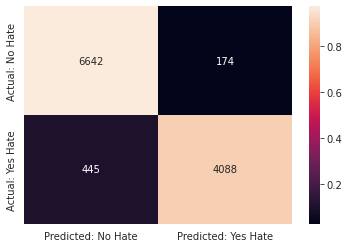

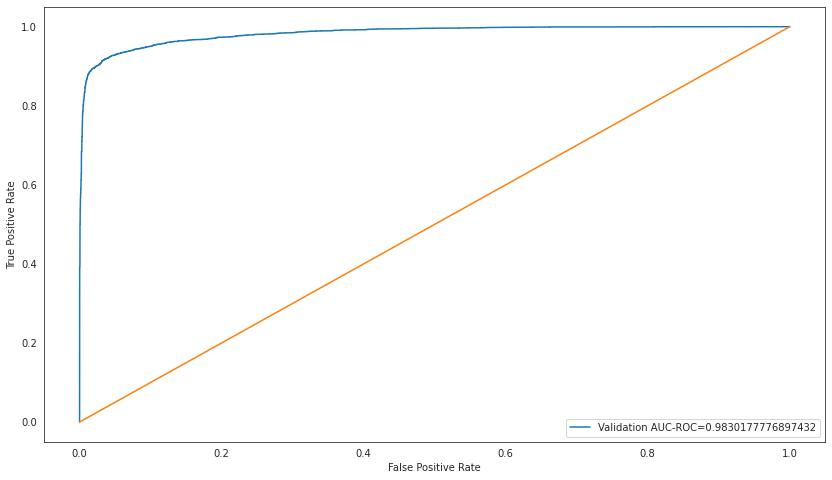

,Actual Label,Predicted_class,Probability
0,0,0,0.075809
1,0,0,0.060295
2,1,1,0.997123
3,0,0,0.004644
4,0,0,0.058031
5,0,0,0.445071
6,0,0,0.413976
7,0,0,0.006579
8,0,0,0.006576
9,1,1,0.997891


In [108]:
lgb_train_new_sm = lgb.Dataset(X_train_new_sm, label=y_train_new_sm)
lgb_test_new_sm = lgb.Dataset(X_test, label=y_test, reference=lgb_train_new_sm)


with mlflow.start_run(experiment_id=experiment_id, run_name='lgb-booster-sm'):
    mlflow.set_tags(tags)
    mlflow.log_params({**params,**fixed_params})
        
    lgb_model_sm = lgb.train({**params,**fixed_params}, lgb_train_new_sm,
                          valid_sets=[lgb_train_new_sm, lgb_test_new_sm],
                          valid_names=['train','valid'],
                          num_boost_round=fixed_params["num_boost_round"],
                          early_stopping_rounds=fixed_params["early_stopping_rounds"])

    train_prob = lgb_model_sm.predict(X_train, num_iteration=lgb_model_sm.best_iteration)
    test_prob = lgb_model_sm.predict(X_test, num_iteration=lgb_model_sm.best_iteration)

    y_pred = binary_predict(test_prob)

    train_auc = roc_auc_score(y_train, train_prob)
    test_auc = roc_auc_score(y_test, test_prob)
    misclass = np.mean(y_pred != y_test)*100
    
    mlflow.log_params({"percent-misclassified":misclass, "SMOTE":'sm'})
    mlflow.log_metrics({"train-auc-score":train_auc,
                        "test-auc-score":test_auc})
    
    
    vec_path = './artifacts'
    mlflow.lightgbm.log_model(lgb_model_ada, artifact_path="models")
    with open(os.path.join(vec_path,'vectorizerV7.bin'), 'wb') as f:
        joblib.dump(tfVectorizer, f)
    mlflow.log_artifact(os.path.join(vec_path,'vectorizerV7.bin'), artifact_path="tfVectorizer")
    
print(f"Train ROC AUC LGBM Model Score with SMOTERandUnder: {train_auc:.4f}")
print(f"Test ROC AUC LGBM Model Score with SMOTERandUnder: {test_auc:.4f}")
print("'%' of Misclassified class:", misclass)

cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, test_prob)
plt.show()

out = pd.DataFrame(y_test[0:30])
out = out.rename(columns={0:'Actual Label'})
out['Predicted_class'] = y_pred[0:30]
out['Probability'] = test_prob[0:30]
out

In [ ]:
# lgb_train_new_sm = lgb.Dataset(X_train_new_sm, label=y_train_new_sm)
# lgb_test_new_sm = lgb.Dataset(X_test, label=y_test, reference=lgb_train_new_sm)


# with mlflow.start_run(experiment_id=experiment_id, run_name='lgb-booster-sm'):
#     mlflow.set_tags(tags)
#     mlflow.log_params({**params,**fixed_params})
        
#     lgb_model_sm = make_pipeline(StandardScaler(),lgb.train({**params,**fixed_params}, lgb_train_new_sm,
#                                                             valid_sets=[lgb_train_new_sm, lgb_test_new_sm],
#                                                             valid_names=['train','valid'],
#                                                             num_boost_round=fixed_params["num_boost_round"],
#                                                             early_stopping_rounds=fixed_params["early_stopping_rounds"])
#                                 )
    

#     train_prob = lgb_model_sm.predict(X_train, num_iteration=lgb_model_sm.best_iteration)
#     test_prob = lgb_model_sm.predict(X_test, num_iteration=lgb_model_sm.best_iteration)

#     y_pred = binary_predict(test_prob)

#     train_auc = roc_auc_score(y_train, train_prob)
#     test_auc = roc_auc_score(y_test, test_prob)
#     misclass = np.mean(y_pred != y_test)*100
    
#     mlflow.log_params({"percent-misclassified":misclass, "SMOTE":'sm'})
#     mlflow.log_metrics({"train-auc-score":train_auc,
#                         "test-auc-score":test_auc})
    
    
#     vec_path = './artifacts'
#     mlflow.lightgbm.log_model(lgb_model_ada, artifact_path="models")
#     with open(os.path.join(vec_path,'vectorizerV7.bin'), 'wb') as f:
#         joblib.dump(tfVectorizer, f)
#     mlflow.log_artifact(os.path.join(vec_path,'vectorizerV7.bin'), artifact_path="tfVectorizer")
    
# print(f"Train ROC AUC LGBM Model Score with SMOTERandUnder: {train_auc:.4f}")
# print(f"Test ROC AUC LGBM Model Score with SMOTERandUnder: {test_auc:.4f}")
# print("'%' of Misclassified class:", misclass)

# cm = confusion_matrix(y_test, y_pred)
# confusion_matrix_plot(cm)
# roc_auc_curve(y_test, test_prob)
# plt.show()

# out = pd.DataFrame(y_test[0:30])
# out = out.rename(columns={0:'Actual Label'})
# out['Predicted_class'] = y_pred[0:30]
# out['Probability'] = test_prob[0:30]
# out

**We will consider the model with no SMOTE because of the low '%' of Misclassified class**

Final LGBMClassifer ROC AUC Score : 0.9830
'%' of Misclassified class: 5.330866155608423


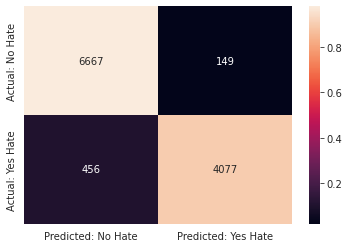

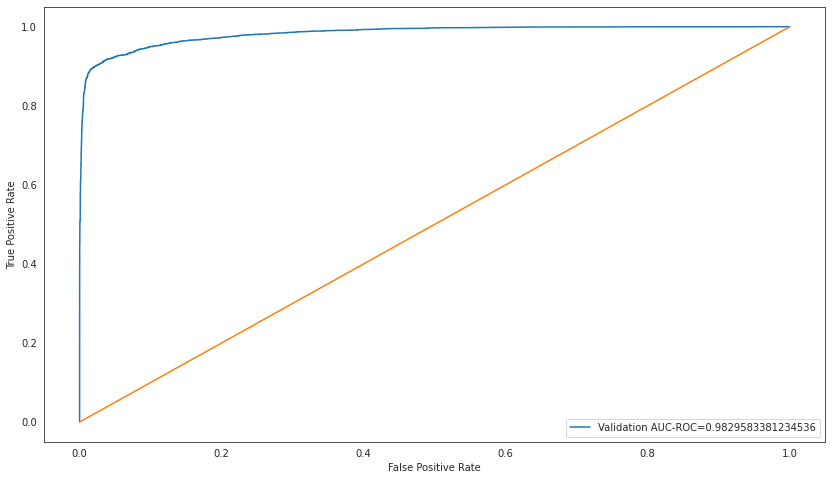

In [40]:
# final_model = make_pipeline(StandardScaler(), lgb.LGBMClassifier(n_estimators=400, reg_alpha=0.1, learning_rate=0.1,
#                                                              objective='binary',
#                                                              class_weight={0:1,1:1}))

# final_model.fit(X_train_new, y_train_new)
# pred = final_model.predict_proba(X_test)[:, 1]
# y_pred = final_model.predict(X_test)
# auc = roc_auc_score(y_test, pred)
# print(f"Final LGBMClassifer ROC AUC Score : {roc_auc_score(y_test, pred):.4f}")
# print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
# cm = confusion_matrix(y_test, y_pred)
# confusion_matrix_plot(cm)
# roc_auc_curve(y_test, pred)
# plt.show()

In [30]:
# sns.distplot(y_pred, label='prediction')
# sns.distplot(y_train_new, label='actual')
# plt.legend()
# plt.show()

# Serialize Tfidf Vectorizer & the Final Model pipeline

In [43]:
# with open('/home/daniel/Desktop/programming/pythondatascience/datascience/NLP/sentiment-hate-system/src/models/modelV6.bin', 'wb') as f:
#     joblib.dump((tfVectorizer, final_model), f)

In [44]:
# with open('/home/daniel/Desktop/programming/pythondatascience/datascience/NLP/sentiment-hate-system/src/vectorizers/vectorizerV5.bin', 'wb') as f:
#     joblib.dump(tfVectorizer, f)
    
# with open('/home/daniel/Desktop/programming/pythondatascience/datascience/NLP/sentiment-hate-system/src/models/modelV5.bin', 'wb') as f:
#     joblib.dump(final_model, f)